**Лабораторная работа  №1**

Белов Владимир Станиславович ББМО-01-23

**Задачи:**
1. Скопировать проект по ссылке в локальную среду выполнения Jupyter (Google Colab) https://github.com/ewatson2/EEL6812_DeepFool_Project
2. Сменить директорию исполнения на вновь созданную папку "EEL6812_DeepFool_Project" проекта.
3. Выполнить импорт библиотек.
4. Выполнить импорт вспомогательных библиотек из локальных файлов проекта.
5. Установить случайное рандомное значение в виде переменной rand_seed=(Порядковый номер ученика группы в Гугл-таблице (6))
6. Установить указанное значение для np.random.seed и torch.manual_seed
7. Использовать в качестсве устройства видеокарту
8. Загрузить датасет MNIST c параметрами mnist_mean = 0.5, mnist_std = 0.5, mnist_dim = 28
9. Загрузить датасет CIFAR-10 c параметрами cifar_mean = [0.491, 0.482, 0.447] cifar_std = [0.202, 0.199, 0.201] cifar_dim = 32
10. Выполнить настройку и загрузку DataLoader batch_size = 64 workers = 4
11. Загрузить и оценить стойкость модели Network-In-Network Model к FGSM и DeepFool атакам на основе датасета CIFAR-10
12. Загрузить и оценить стойкость модели LeNet к FGSM и DeepFool атакам на основе датасета CIFAR-10
13. Выполнить оценку атакующих примеров для сетей.
14. Подготовить отчет в формате pdf.



1. Скопируем проект по ссылке в локальную среду выполнения Jupyter.

In [2]:
!git clone https://github.com/ewatson2/EEL6812_DeepFool_Project.git

Cloning into 'EEL6812_DeepFool_Project'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 96 (delta 2), reused 1 (delta 1), pack-reused 93 (from 1)
Receiving objects: 100% (96/96), 33.99 MiB | 10.71 MiB/s, done.
Resolving deltas: 100% (27/27), done.


2. Сменить директорию исполнения на вновь созданную папку "EEL6812_DeepFool_Project" проекта.

In [57]:
cd /content/EEL6812_DeepFool_Project

/content/EEL6812_DeepFool_Project


3. Выполним импорт библиотек, необходимых для нашей работы.


In [4]:
import numpy as np
import json, torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms


4. Теперь выполним импорт вспомогательных библиотек из локальных файлов проекта.

In [5]:
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack


5. Установим случайное рандомное значение в виде переменной rand_seed=(6)

image.png

In [6]:
rand_seed = 6

6. Установим указанное значение для np.random.seed и torch.manual_seed

In [7]:
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

7. Будем использовать в качестсве устройства видеокарту

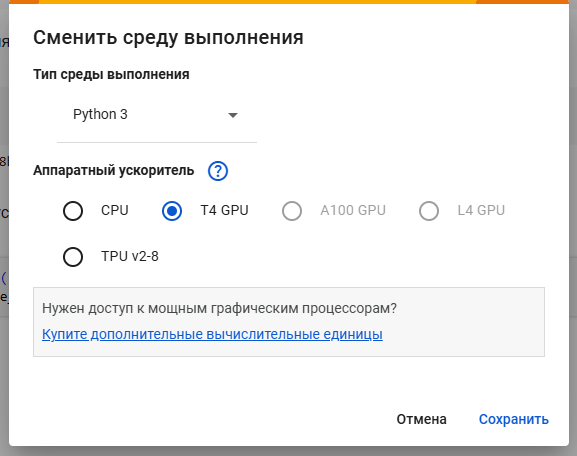

8. Загрузим датасет MNIST c параметрами mnist_mean = 0.5, mnist_std = 0.5, mnist_dim = 28

In [39]:
mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

mnist_min, mnist_max = get_clip_bounds(mnist_mean, mnist_std, mnist_dim)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)
mnist_tf = transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean=mnist_mean, std=mnist_std)])
mnist_tf_train = transforms.Compose([ transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize( mean=mnist_mean, std=mnist_std)])
mnist_tf_inv = transforms.Compose([ transforms.Normalize( mean=0.0, std=np.divide(1.0, mnist_std)), transforms.Normalize( mean=np.multiply(-1.0, mnist_std), std=1.0)])
mnist_temp = datasets.MNIST(root='datasets/mnist', train=True, download=True, transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])
mnist_test = datasets.MNIST(root='datasets/mnist', train=False, download=True, transform=mnist_tf)

9. Загрузим датасет CIFAR-10 c параметрами cifar_mean = [0.491, 0.482, 0.447] cifar_std = [0.202, 0.199, 0.201] cifar_dim = 32

In [64]:
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32

cifar_min, cifar_max = get_clip_bounds(cifar_mean, cifar_std, cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)
cifar_tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=cifar_mean, std=cifar_std)])
cifar_tf_train = transforms.Compose([transforms.RandomCrop(size=cifar_dim, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(mean=cifar_mean, std=cifar_std)])
cifar_tf_inv = transforms.Compose([transforms.Normalize(mean=[0.0, 0.0, 0.0], std=np.divide(1.0, cifar_std)), transforms.Normalize(mean=np.multiply(-1.0, cifar_mean), std=[1.0, 1.0, 1.0])])
cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True, download=True, transform=cifar_tf_train)
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])
cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False, download=True, transform=cifar_tf)
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


10. Выполним настройку и загрузку DataLoader

In [65]:
batch_size = 64
workers = 4

mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=workers)

11. Загрузим и оценим стойкость модели Network-In-Network Model к FGSM и DeepFool атакам на основе датасета CIFAR-10

In [98]:
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=torch.device('cpu')))
evaluate_attack('cifar_nin_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')

deep_args = [10, 10, 0.02, 50] # Задаём гиперпараметры DeepFool
evaluate_attack('cifar_nin_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)
if device.type == 'cuda': torch.cuda.empty_cache()
print('')

FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 0.67 s
FGSM Time (Per Image) : 67.07 us

DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms



12. Загрузим и оценим стойкость модели LeNet к FGSM и DeepFool атакам на основе датасета CIFAR-10

In [99]:
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device('cpu')))
evaluate_attack('cifar_lenet_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_lenet_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)
if device.type == 'cuda': torch.cuda.empty_cache()

FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us

DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms


 13. Выполним оценку атакующих примеров для сетей.

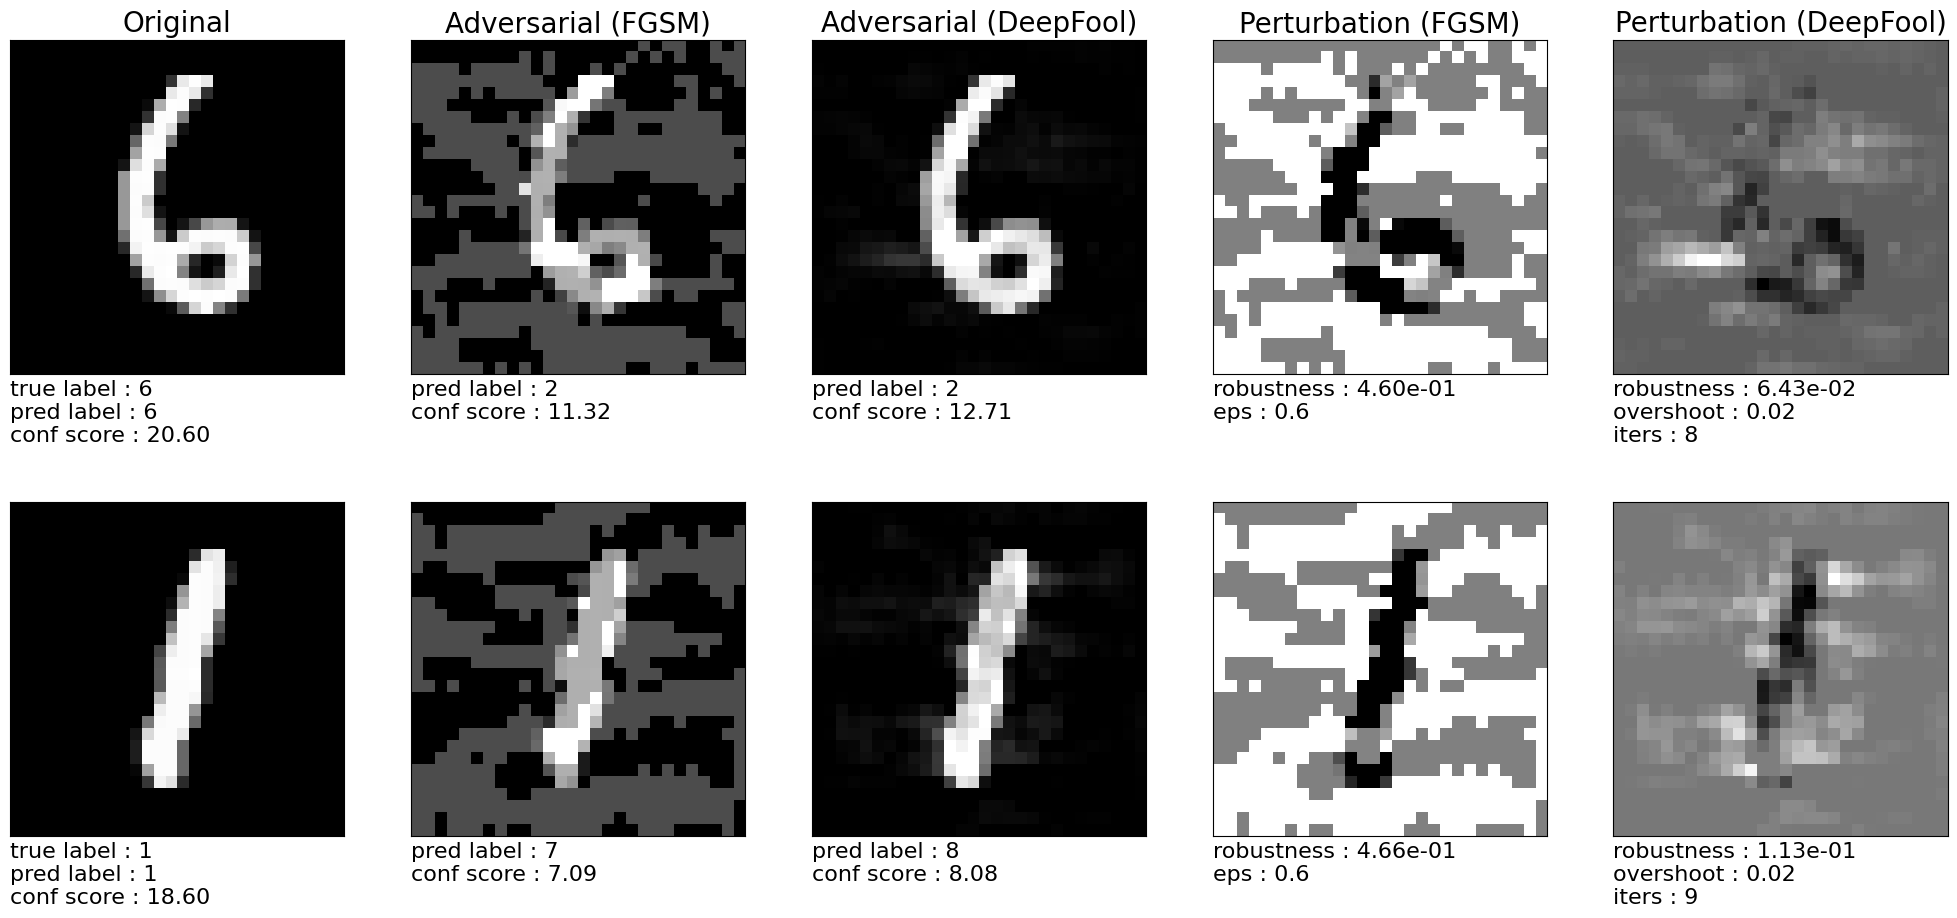

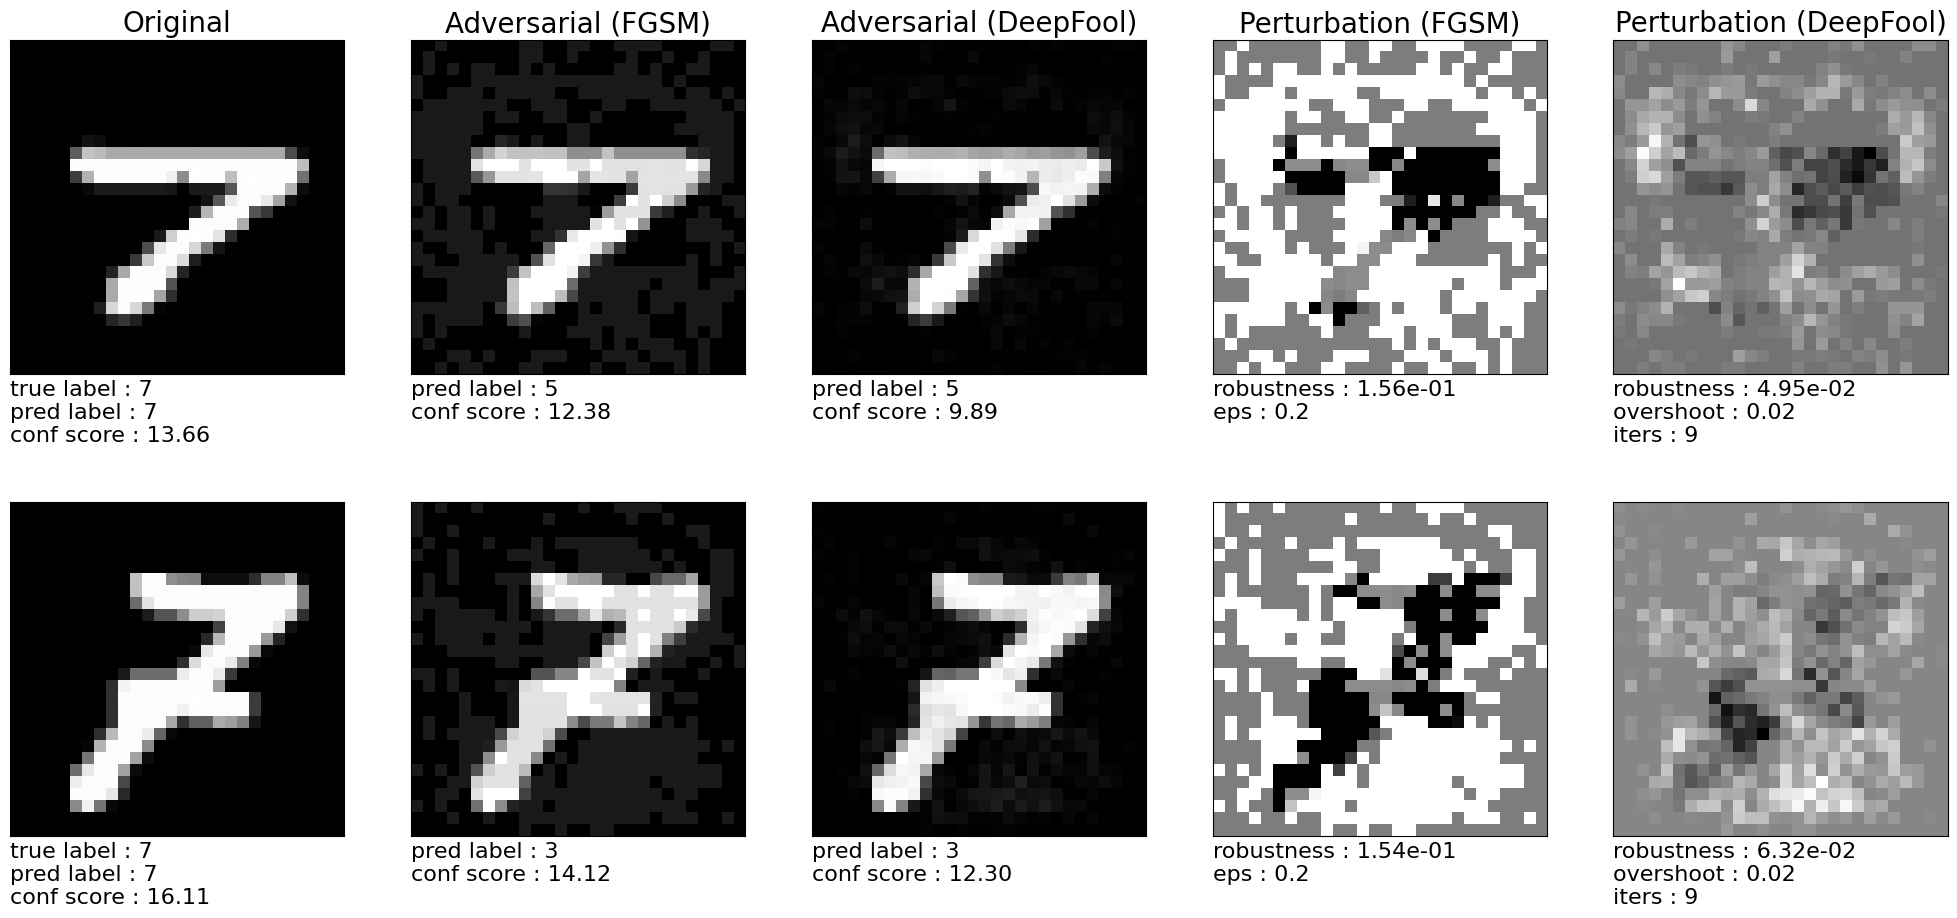

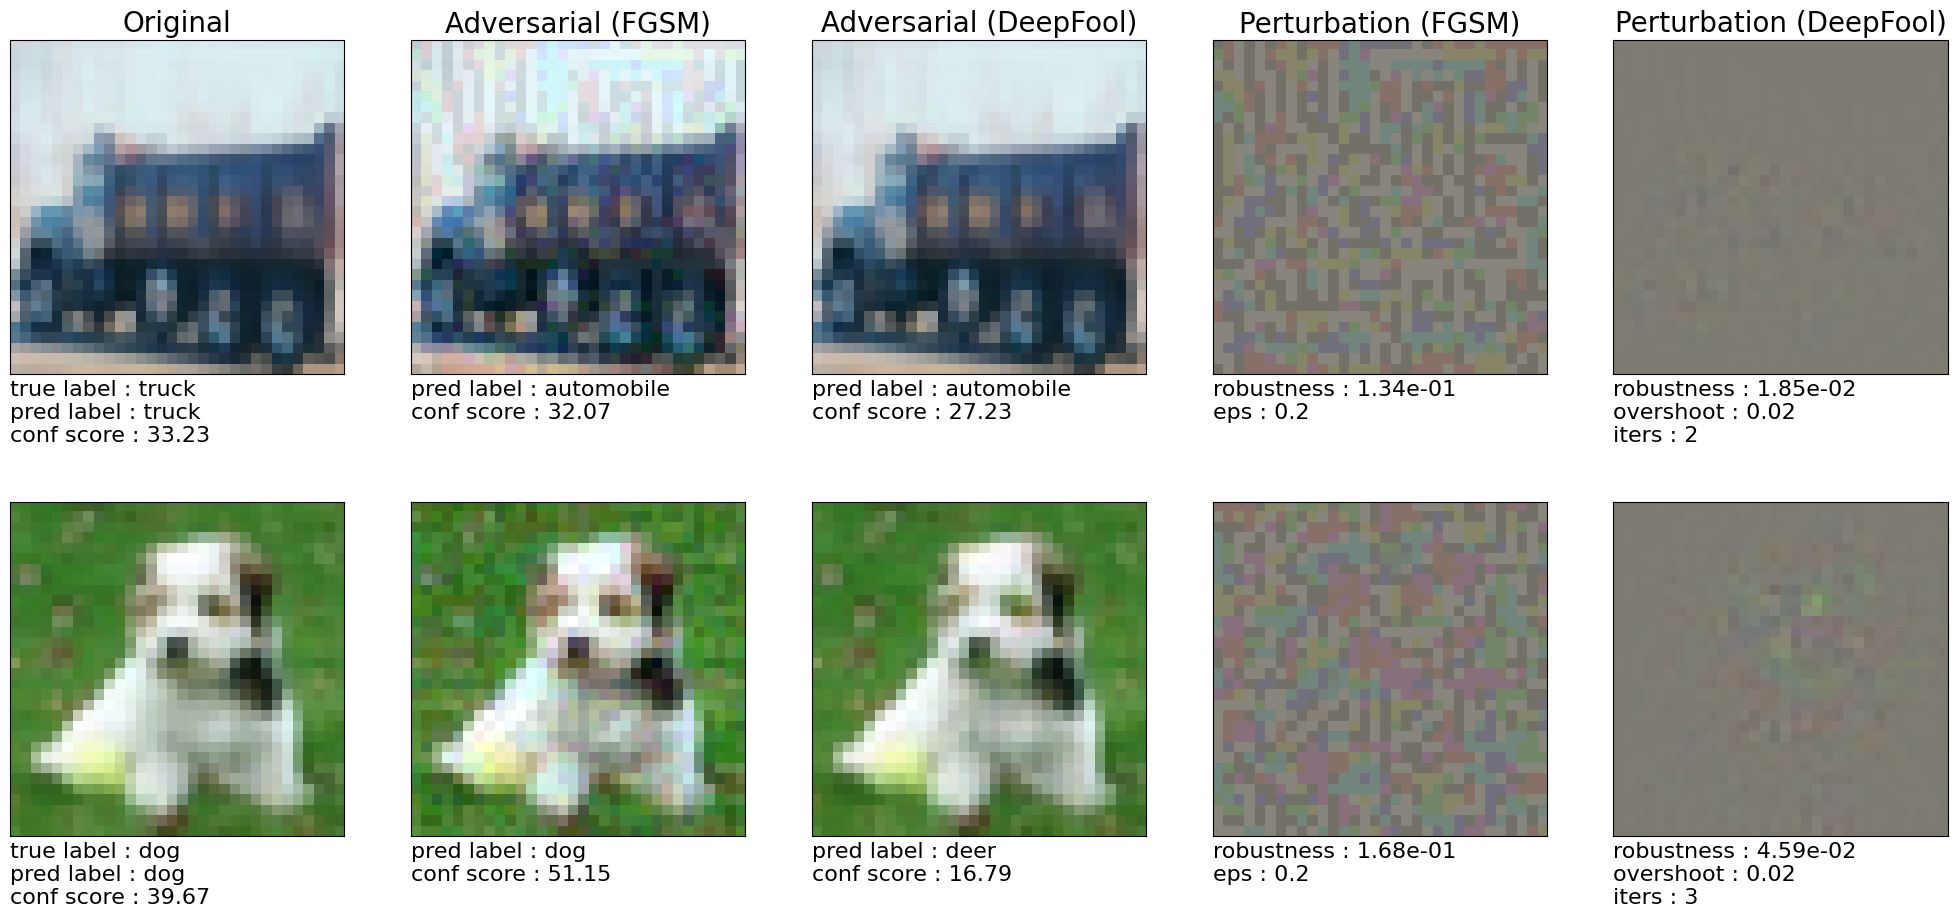

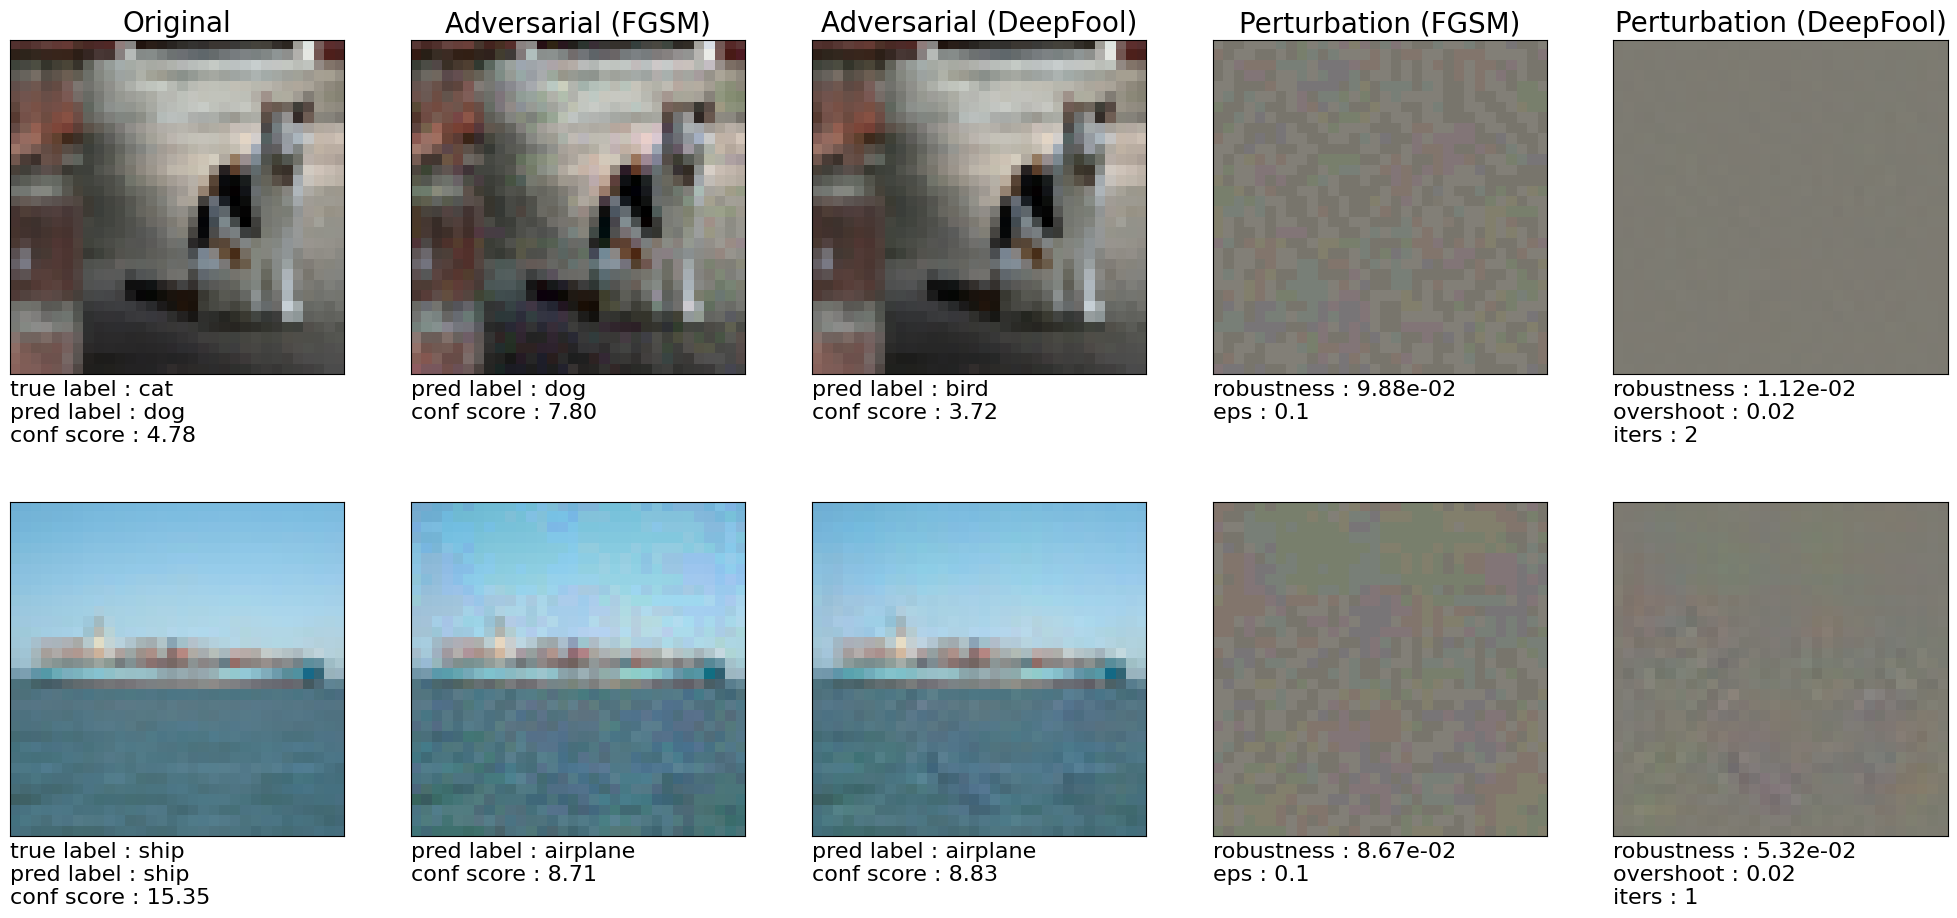

In [100]:
#LeNet
fgsm_eps = 0.6
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
if device.type == 'cuda': torch.cuda.empty_cache()
#FCNet
fgsm_eps = 0.2
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
if device.type == 'cuda': torch.cuda.empty_cache()
#Network-in-Network
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)
if device.type == 'cuda': torch.cuda.empty_cache()
#LeNet CIFAR-10
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)
if device.type == 'cuda': torch.cuda.empty_cache()




14. Отразить отличия для fgsm_eps=(0.001, 0.02, 0.5, 0.9, 10) и
выявить закономерность/обнаружить отсутсвие влияние параметра eps для сетей FC LeNet на датасете MNIST, NiN LeNEt на датасете CIFAR

Величина fsgsm_eps = 0.001:
FGSM Test Error : 1.69%
FGSM Robustness : 8.06e-04
FGSM Time (All Images) : 1.39 s
FGSM Time (Per Image) : 138.78 us


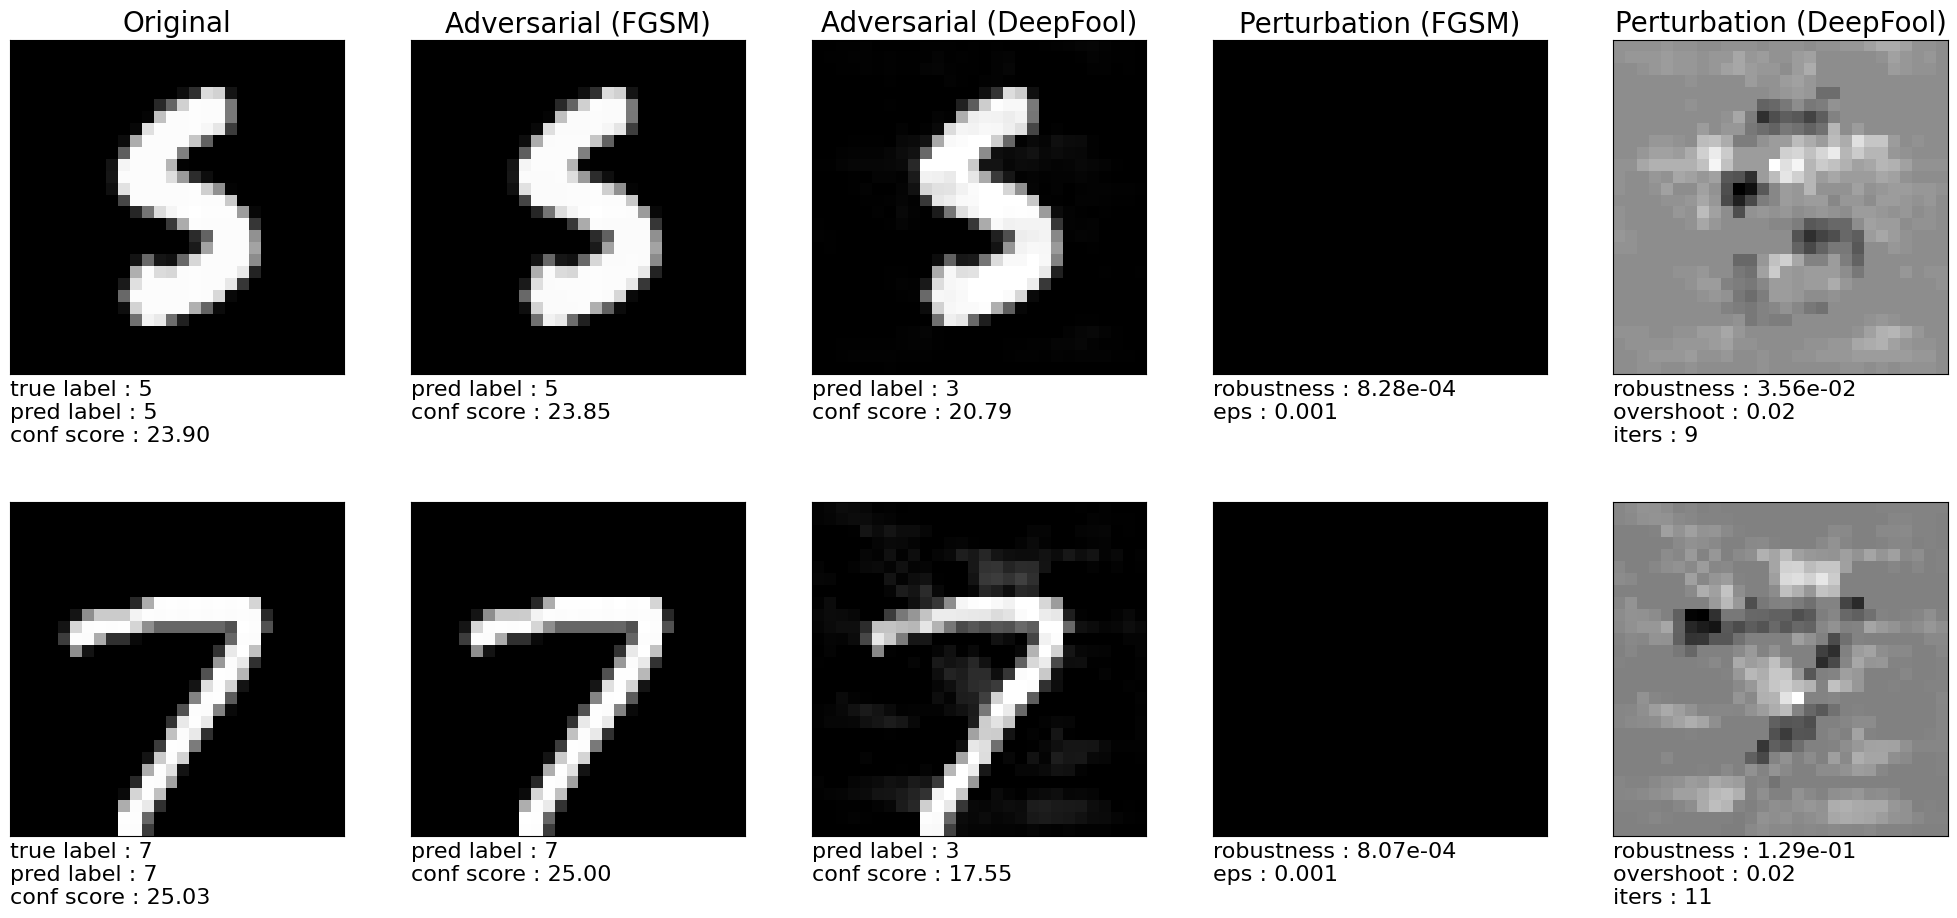


Величина fsgsm_eps = 0.02:
FGSM Test Error : 2.56%
FGSM Robustness : 1.59e-02
FGSM Time (All Images) : 0.90 s
FGSM Time (Per Image) : 90.08 us


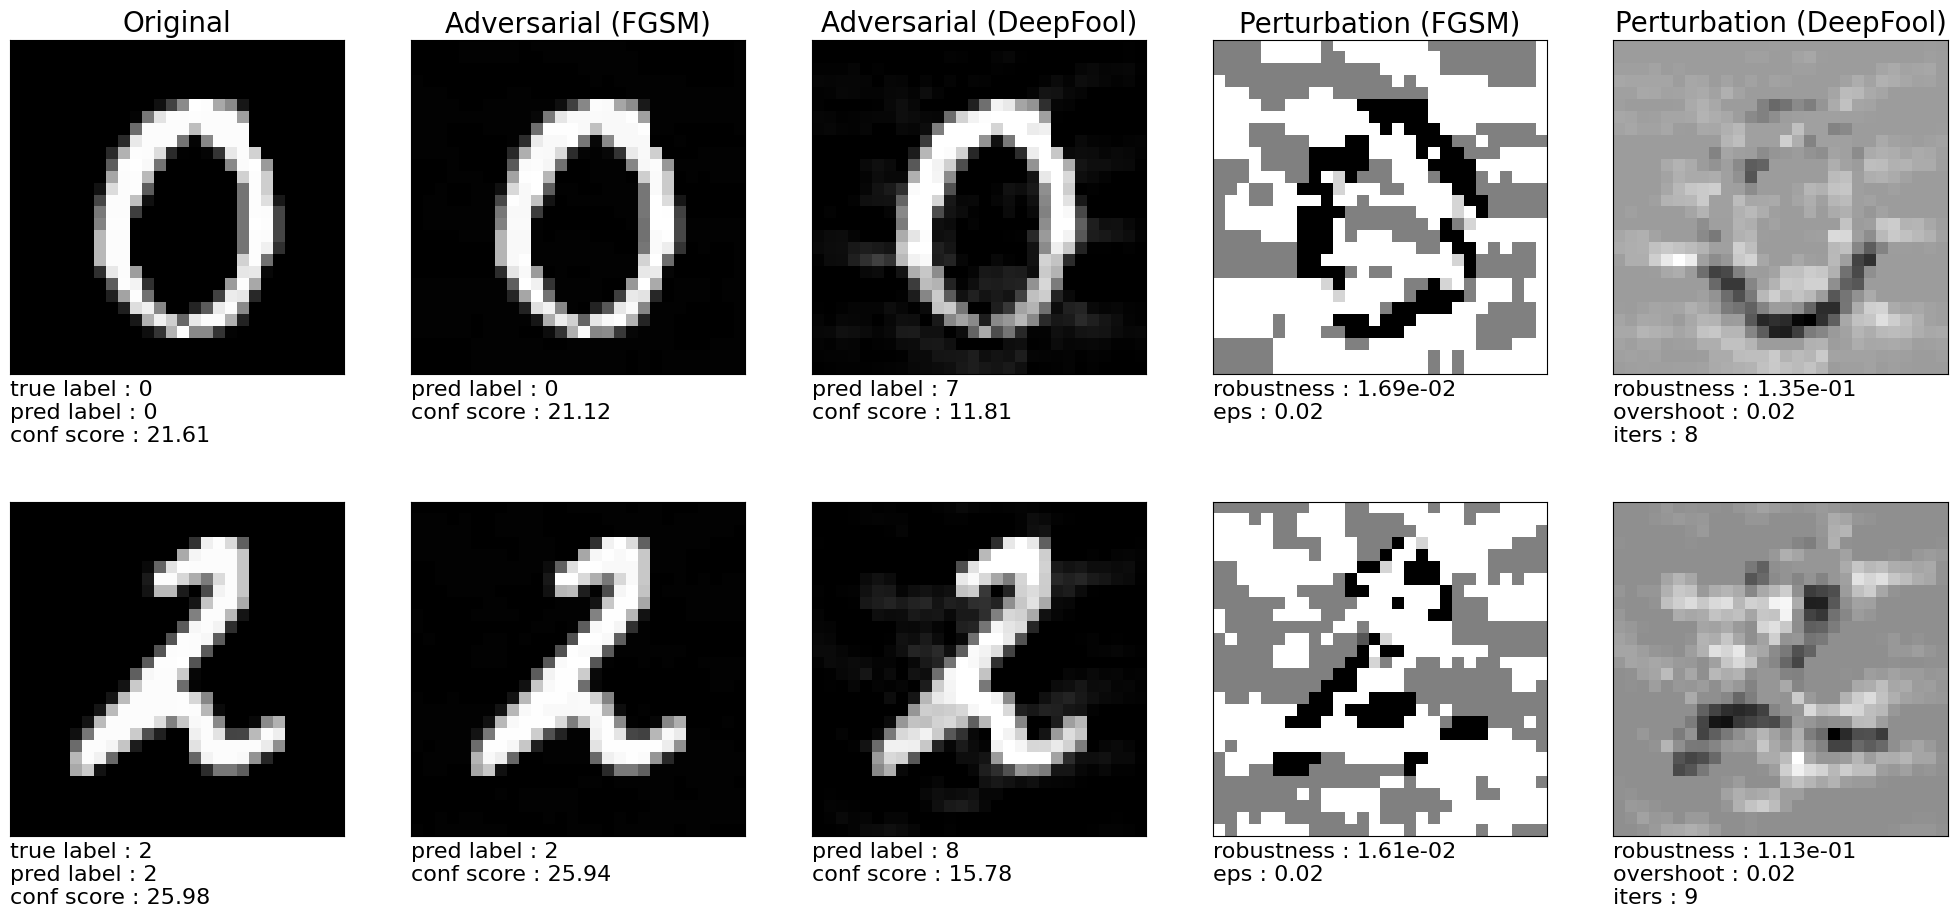


Величина fsgsm_eps = 0.5:
FGSM Test Error : 82.92%
FGSM Robustness : 3.83e-01
FGSM Time (All Images) : 0.92 s
FGSM Time (Per Image) : 91.50 us


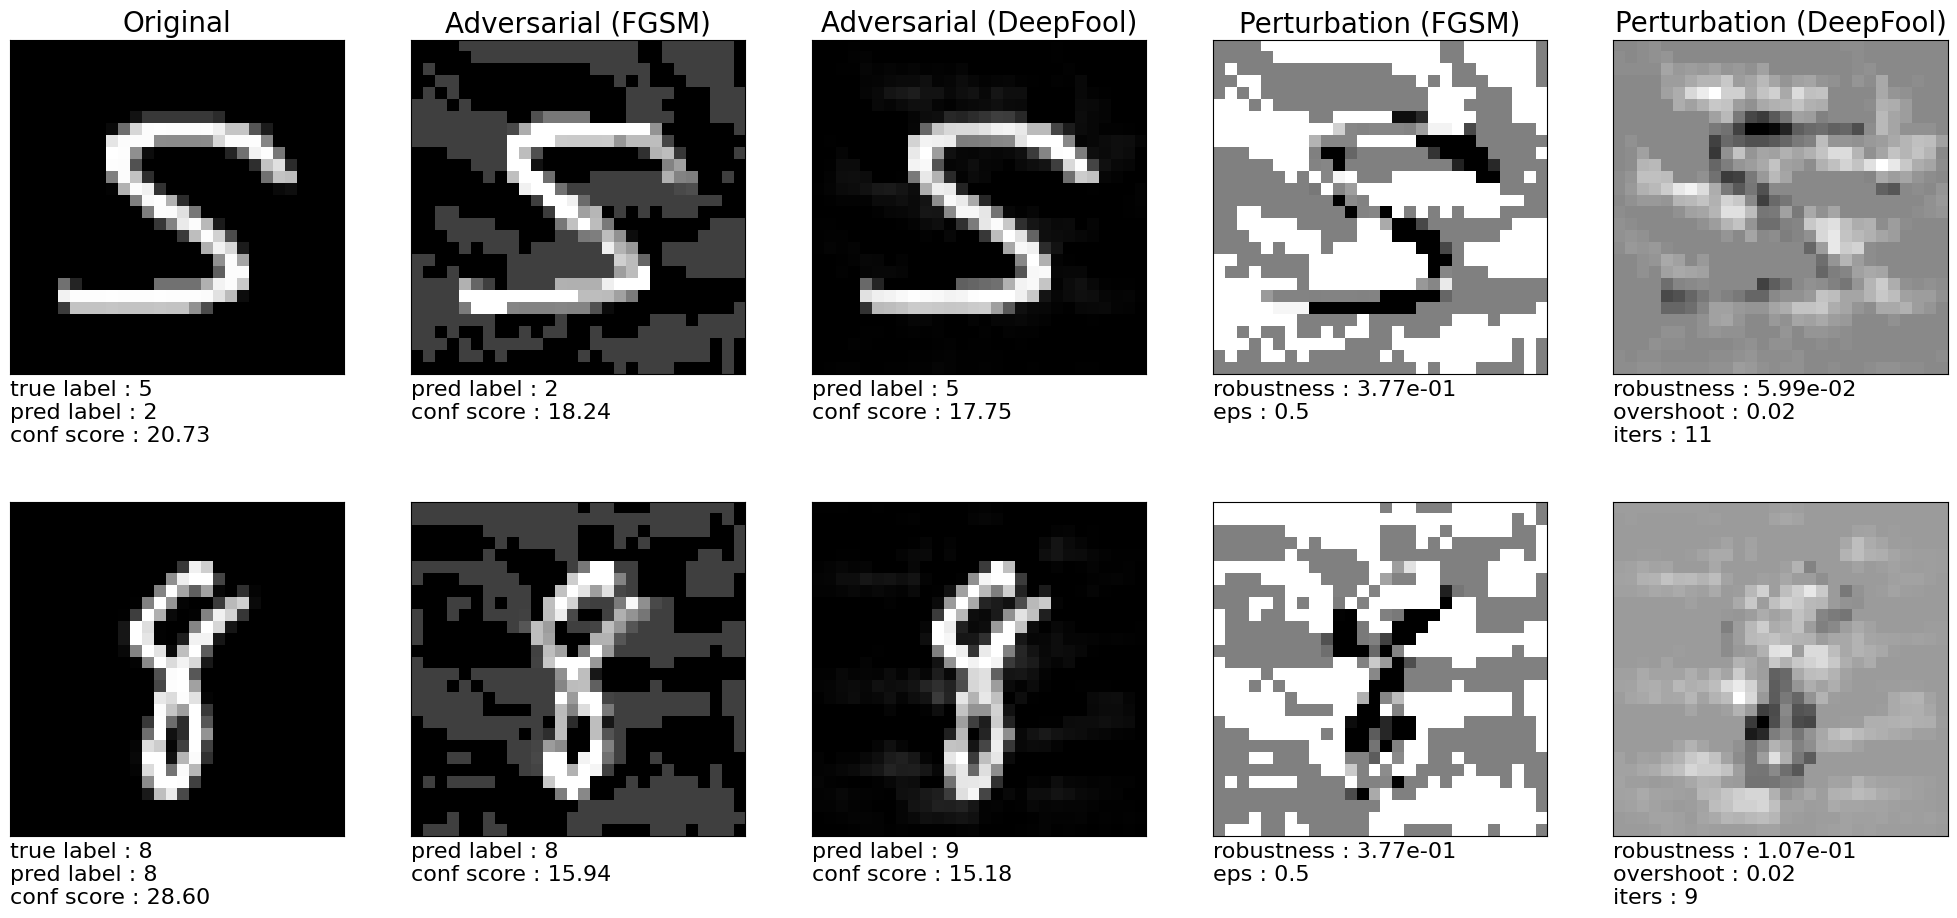


Величина fsgsm_eps = 0.9:
FGSM Test Error : 93.80%
FGSM Robustness : 6.81e-01
FGSM Time (All Images) : 1.05 s
FGSM Time (Per Image) : 105.03 us


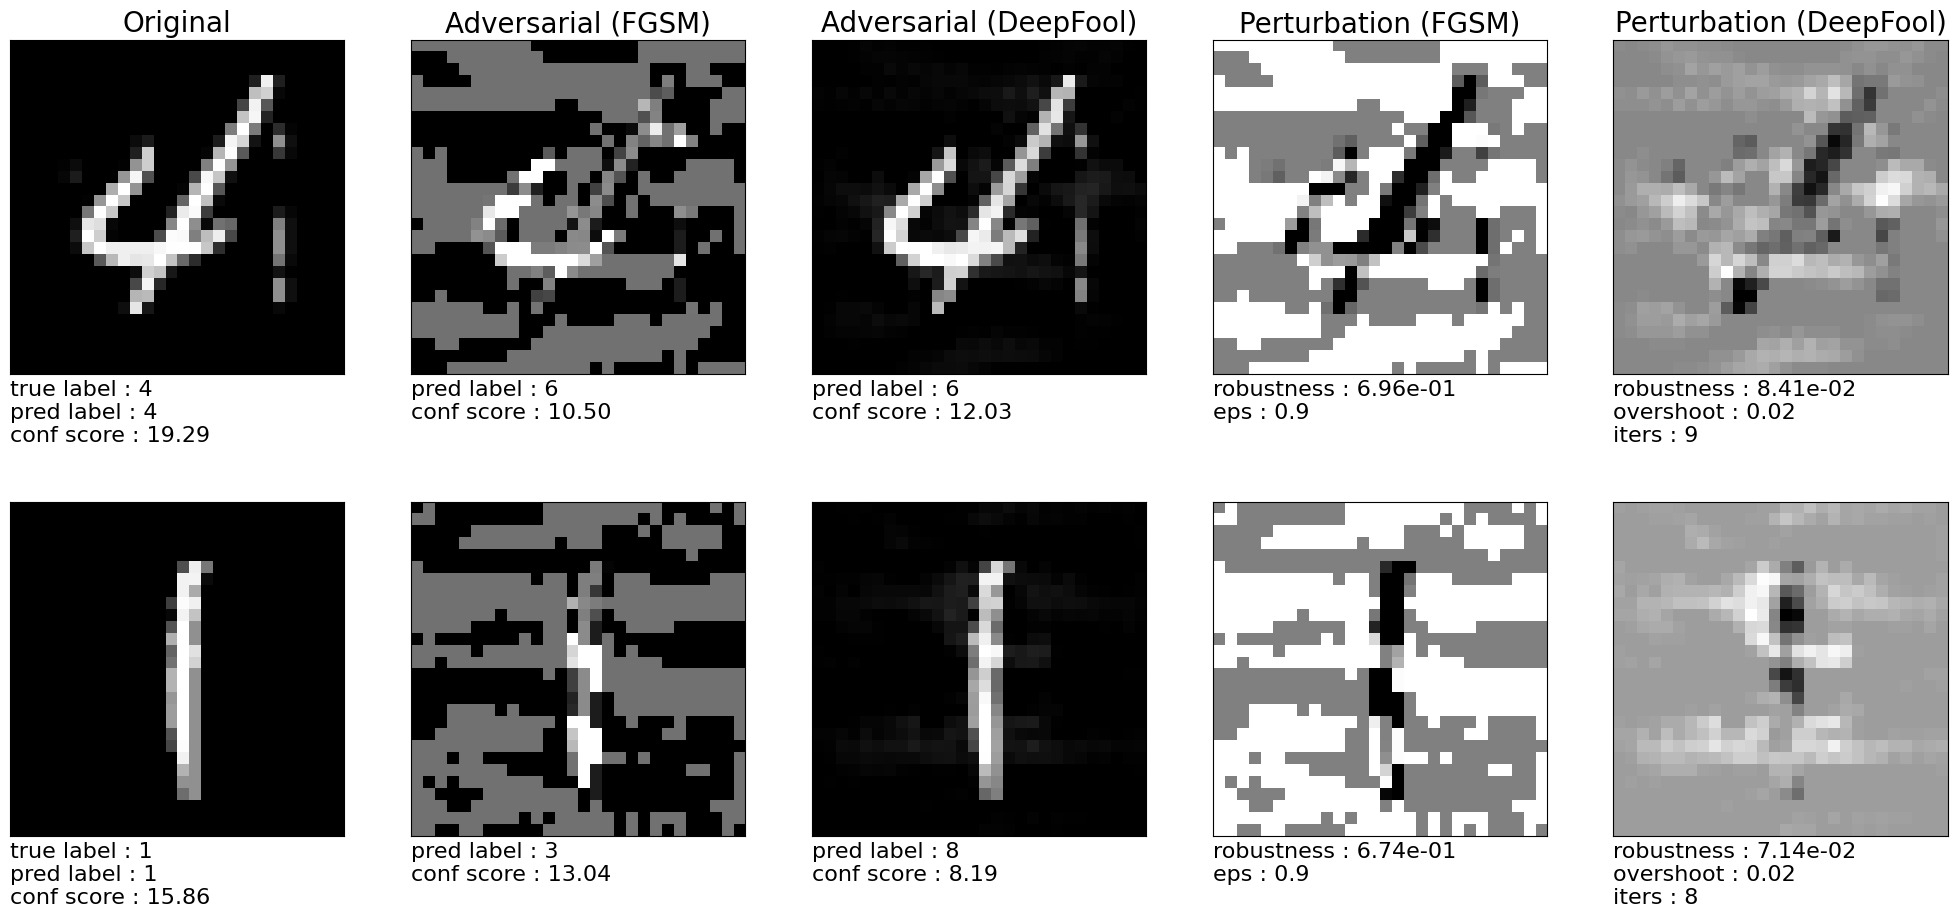


Величина fsgsm_eps = 10:
FGSM Test Error : 94.15%
FGSM Robustness : 1.46e+00
FGSM Time (All Images) : 1.09 s
FGSM Time (Per Image) : 109.36 us


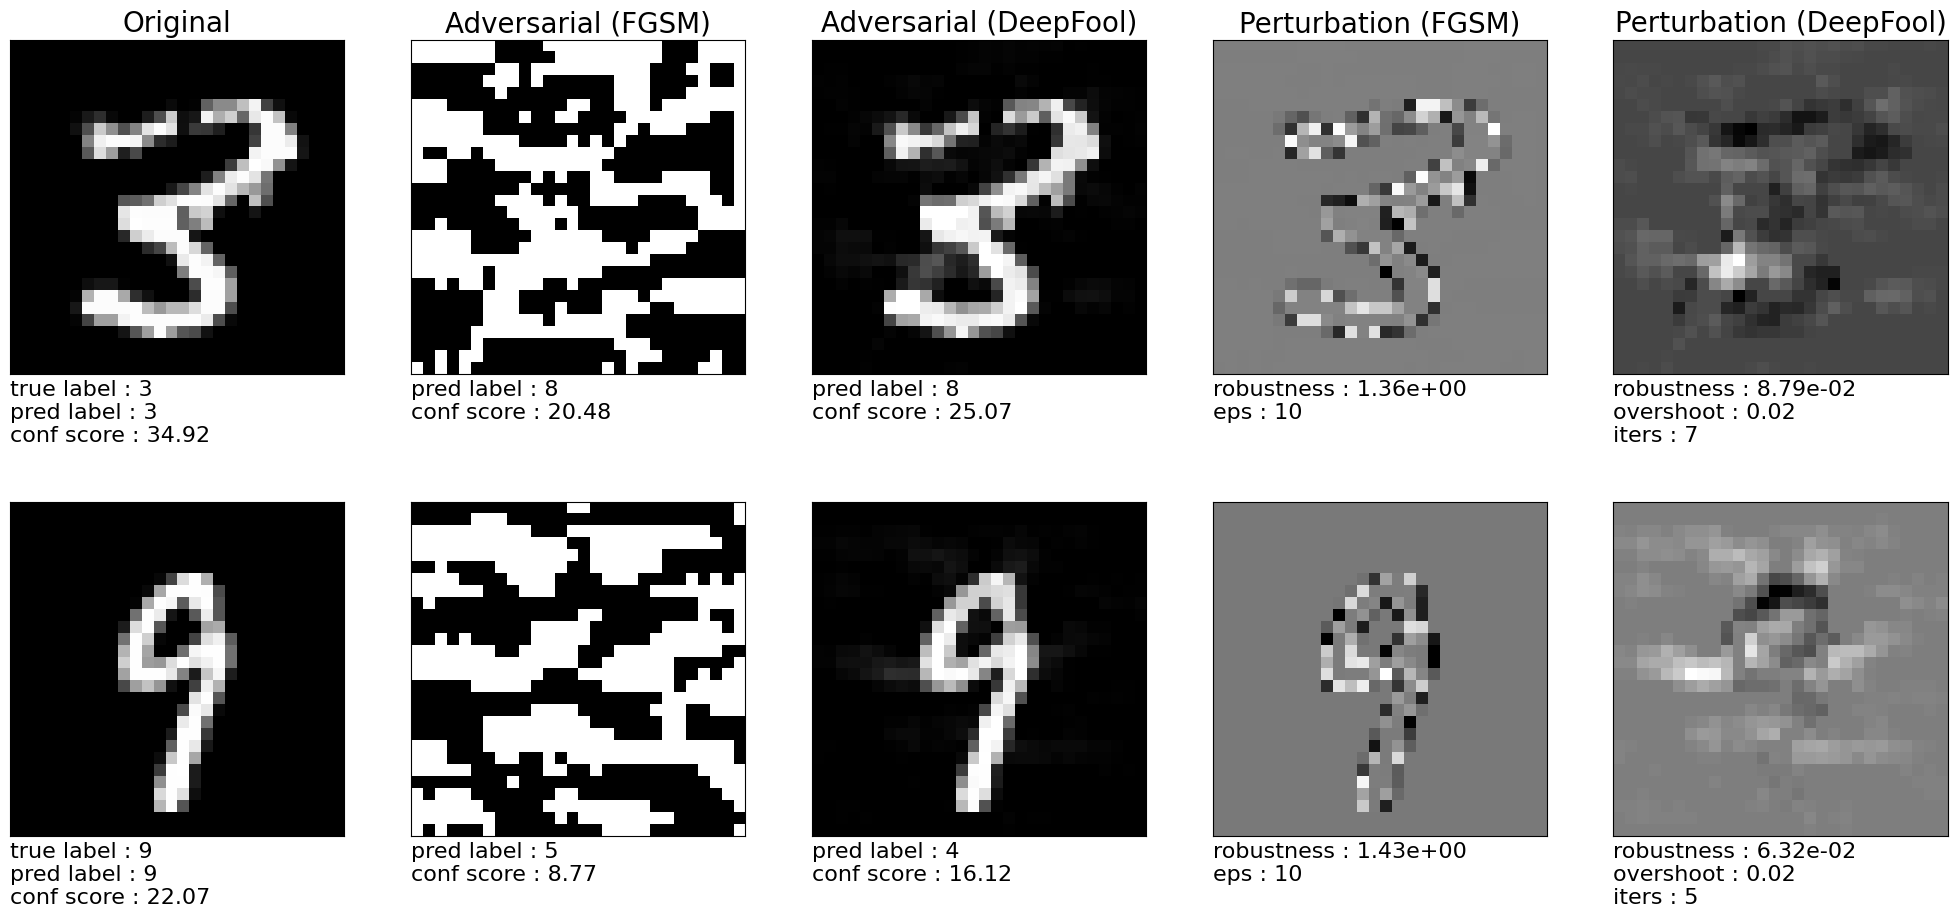

In [131]:
#LeNet
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

for fgsm_eps in [0.001, 0.02, 0.5, 0.9, 10]:
  print(f"Величина fsgsm_eps = {fgsm_eps}:")
  mnist_lenet_fgsm = 'mnist_lenet_fgsm' + str(fgsm_eps) + '.csv'
  evaluate_attack(mnist_lenet_fgsm, 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
  display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
  if device.type == 'cuda': torch.cuda.empty_cache()
  print('')

Величина fsgsm_eps = 0.001:
FGSM Test Error : 3.07%
FGSM Robustness : 8.08e-04
FGSM Time (All Images) : 0.56 s
FGSM Time (Per Image) : 56.10 us


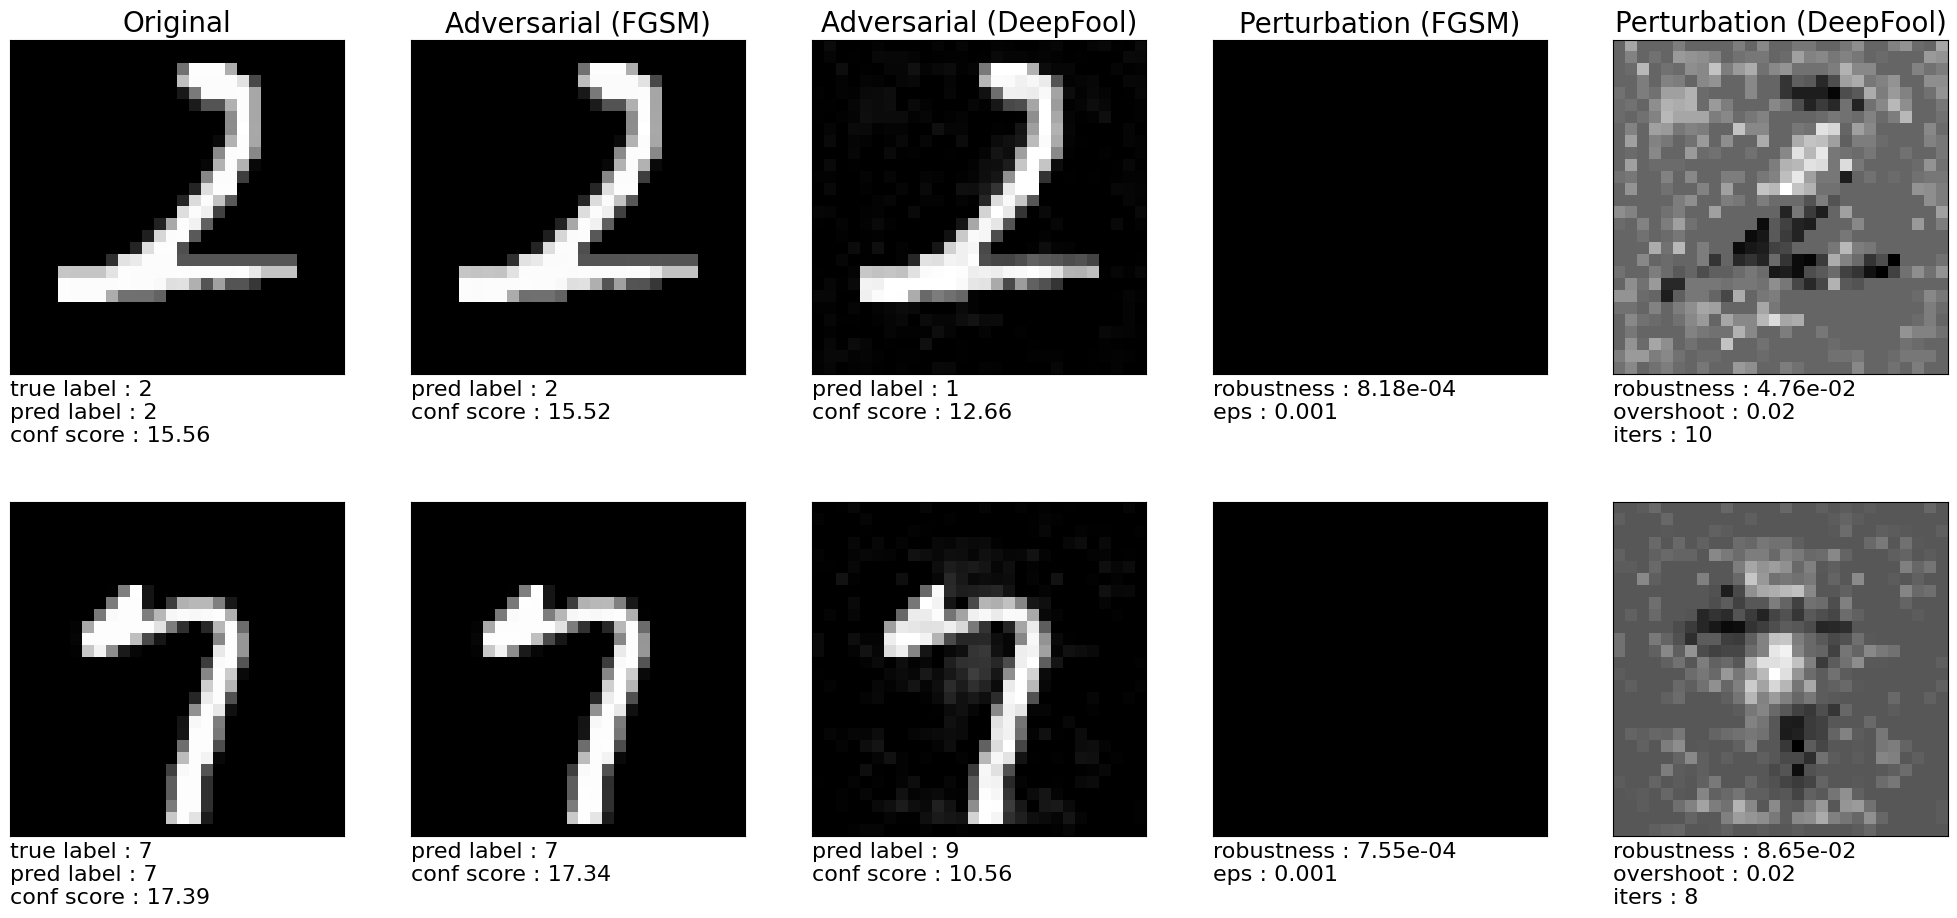


Величина fsgsm_eps = 0.02:
FGSM Test Error : 5.54%
FGSM Robustness : 1.60e-02
FGSM Time (All Images) : 0.72 s
FGSM Time (Per Image) : 72.39 us


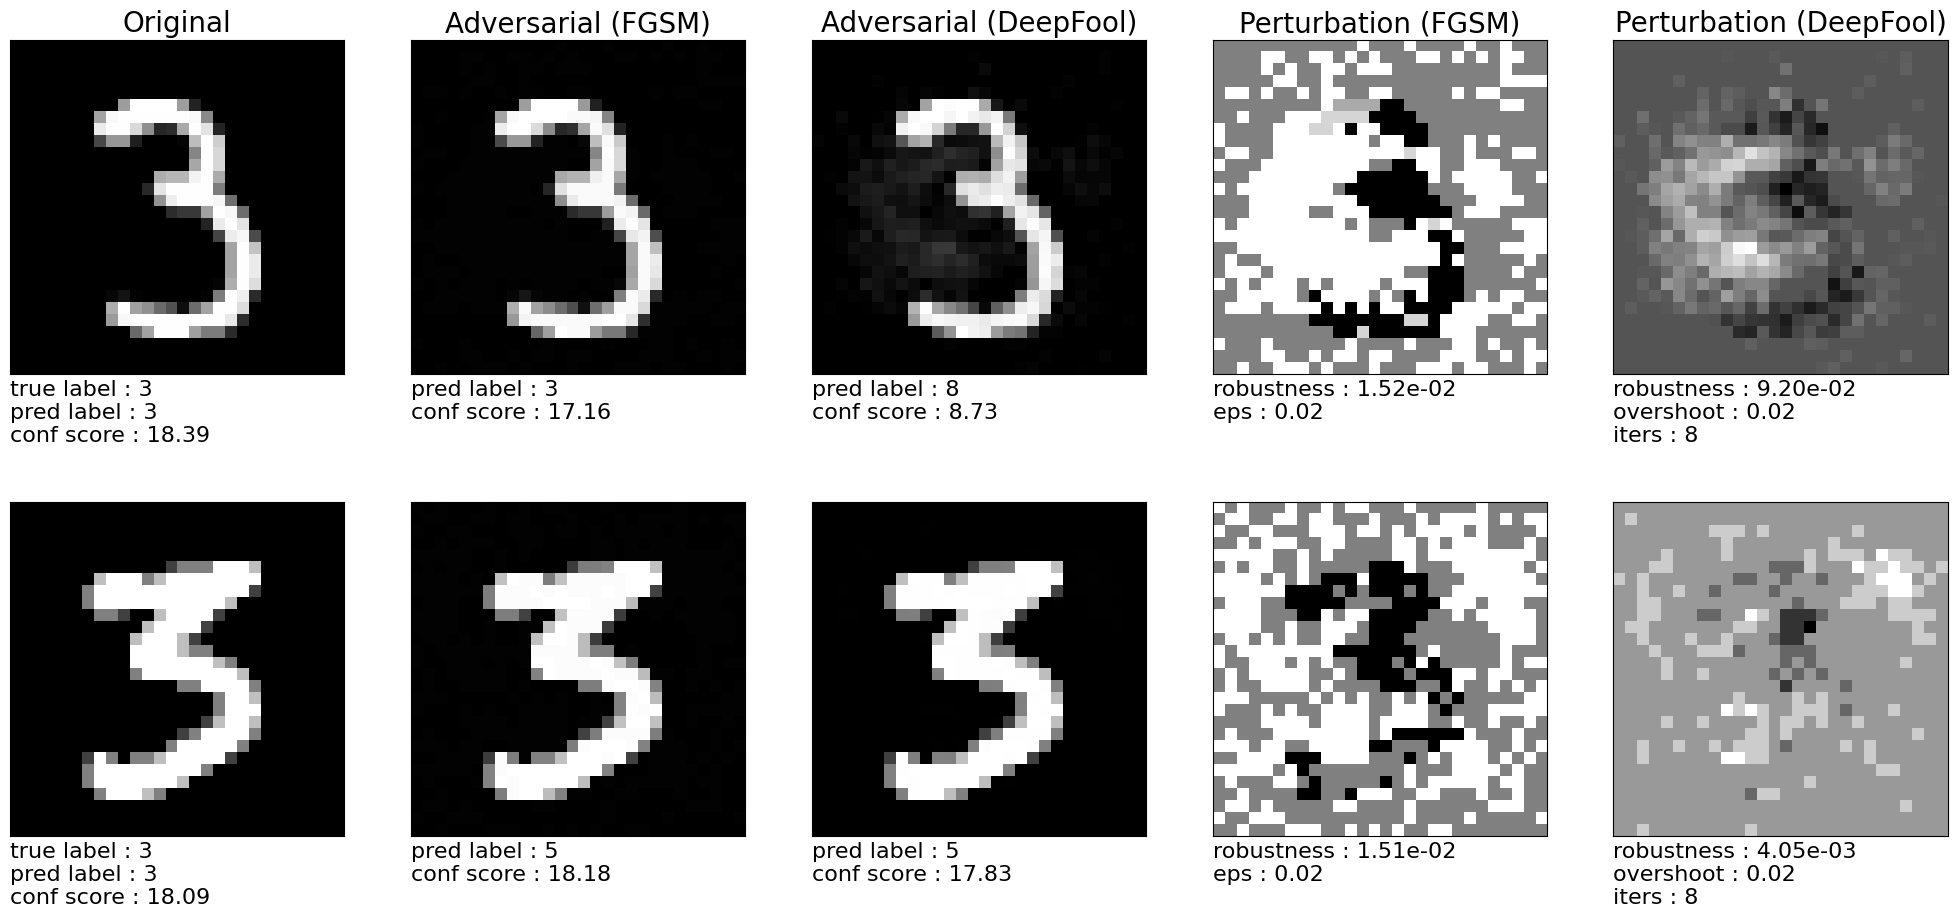


Величина fsgsm_eps = 0.5:
FGSM Test Error : 99.21%
FGSM Robustness : 3.86e-01
FGSM Time (All Images) : 0.59 s
FGSM Time (Per Image) : 59.29 us


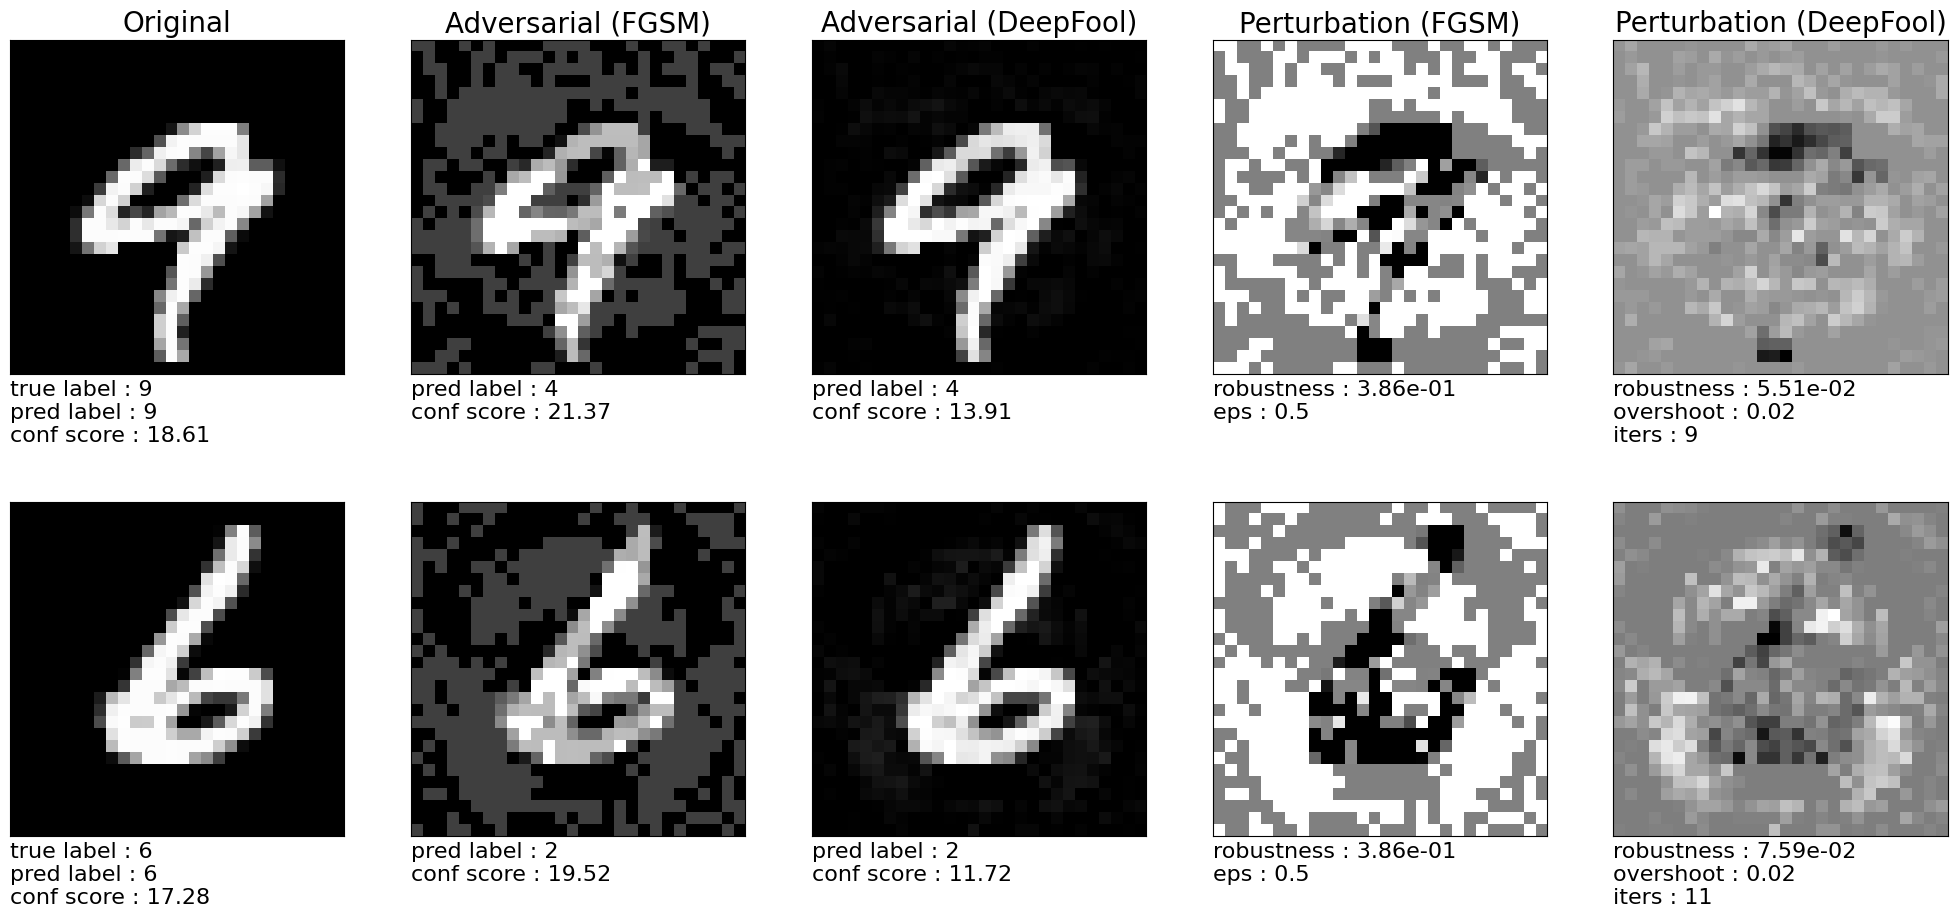


Величина fsgsm_eps = 0.9:
FGSM Test Error : 99.87%
FGSM Robustness : 6.86e-01
FGSM Time (All Images) : 0.55 s
FGSM Time (Per Image) : 54.75 us


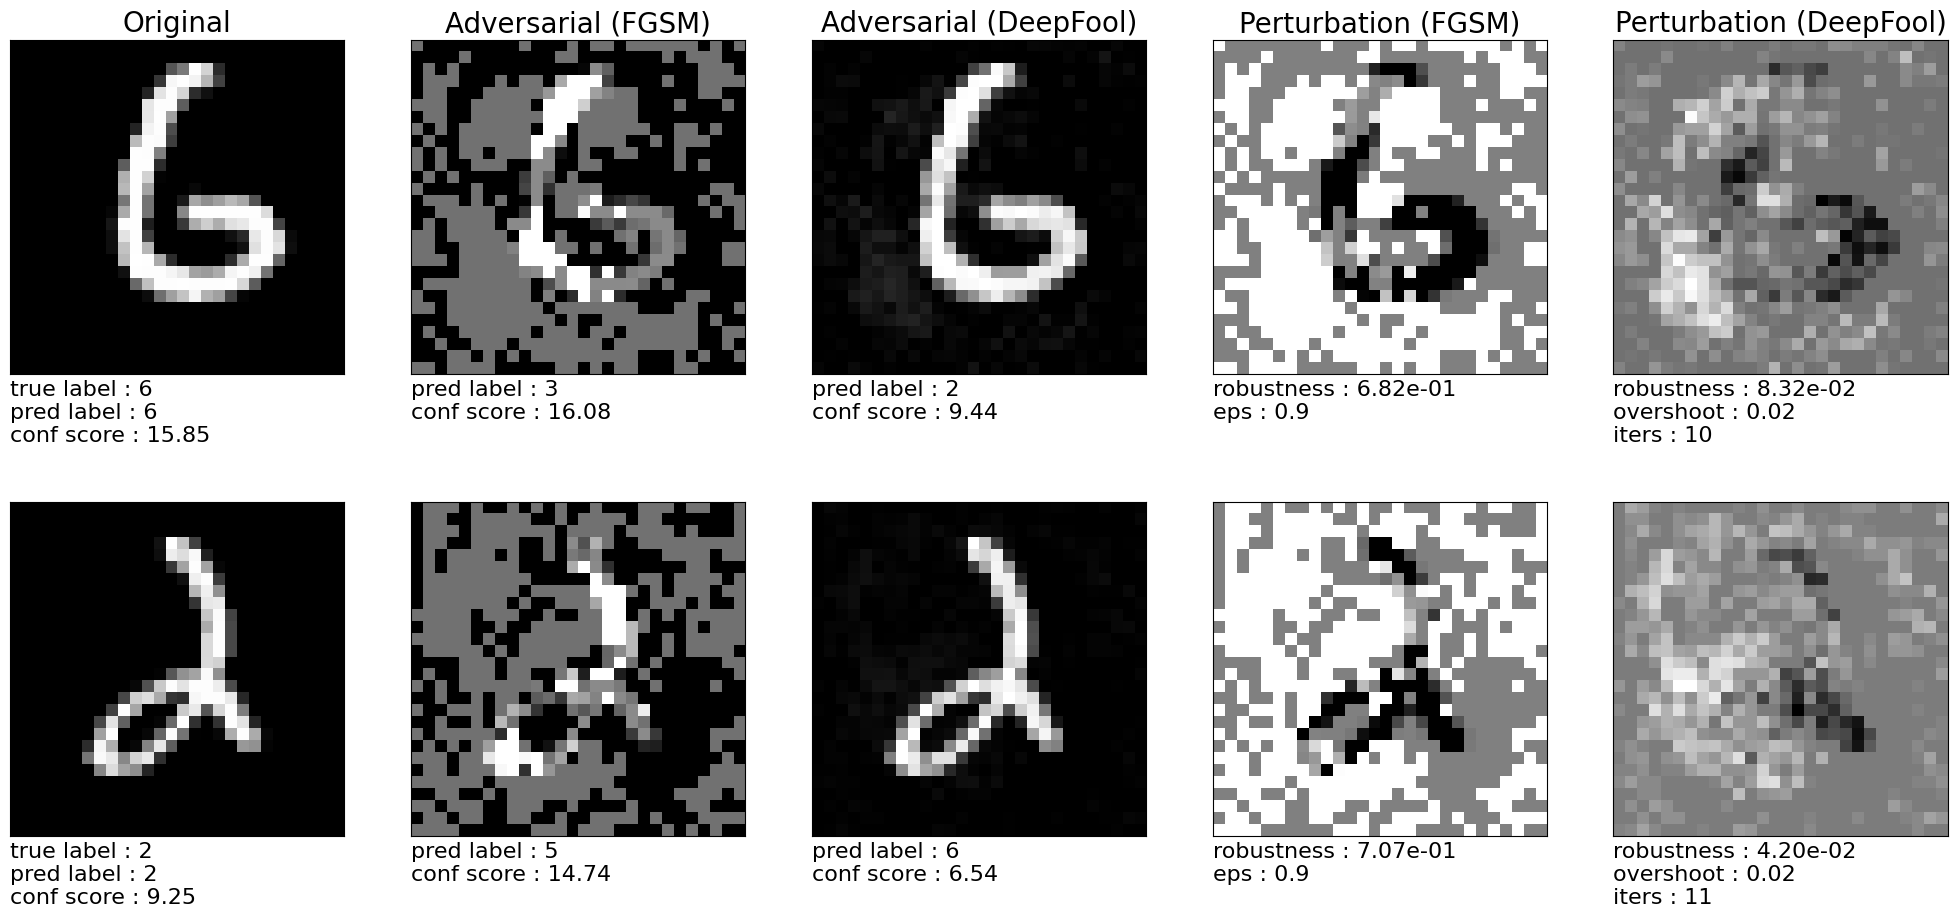


Величина fsgsm_eps = 10:
FGSM Test Error : 99.87%
FGSM Robustness : 1.47e+00
FGSM Time (All Images) : 0.57 s
FGSM Time (Per Image) : 57.50 us


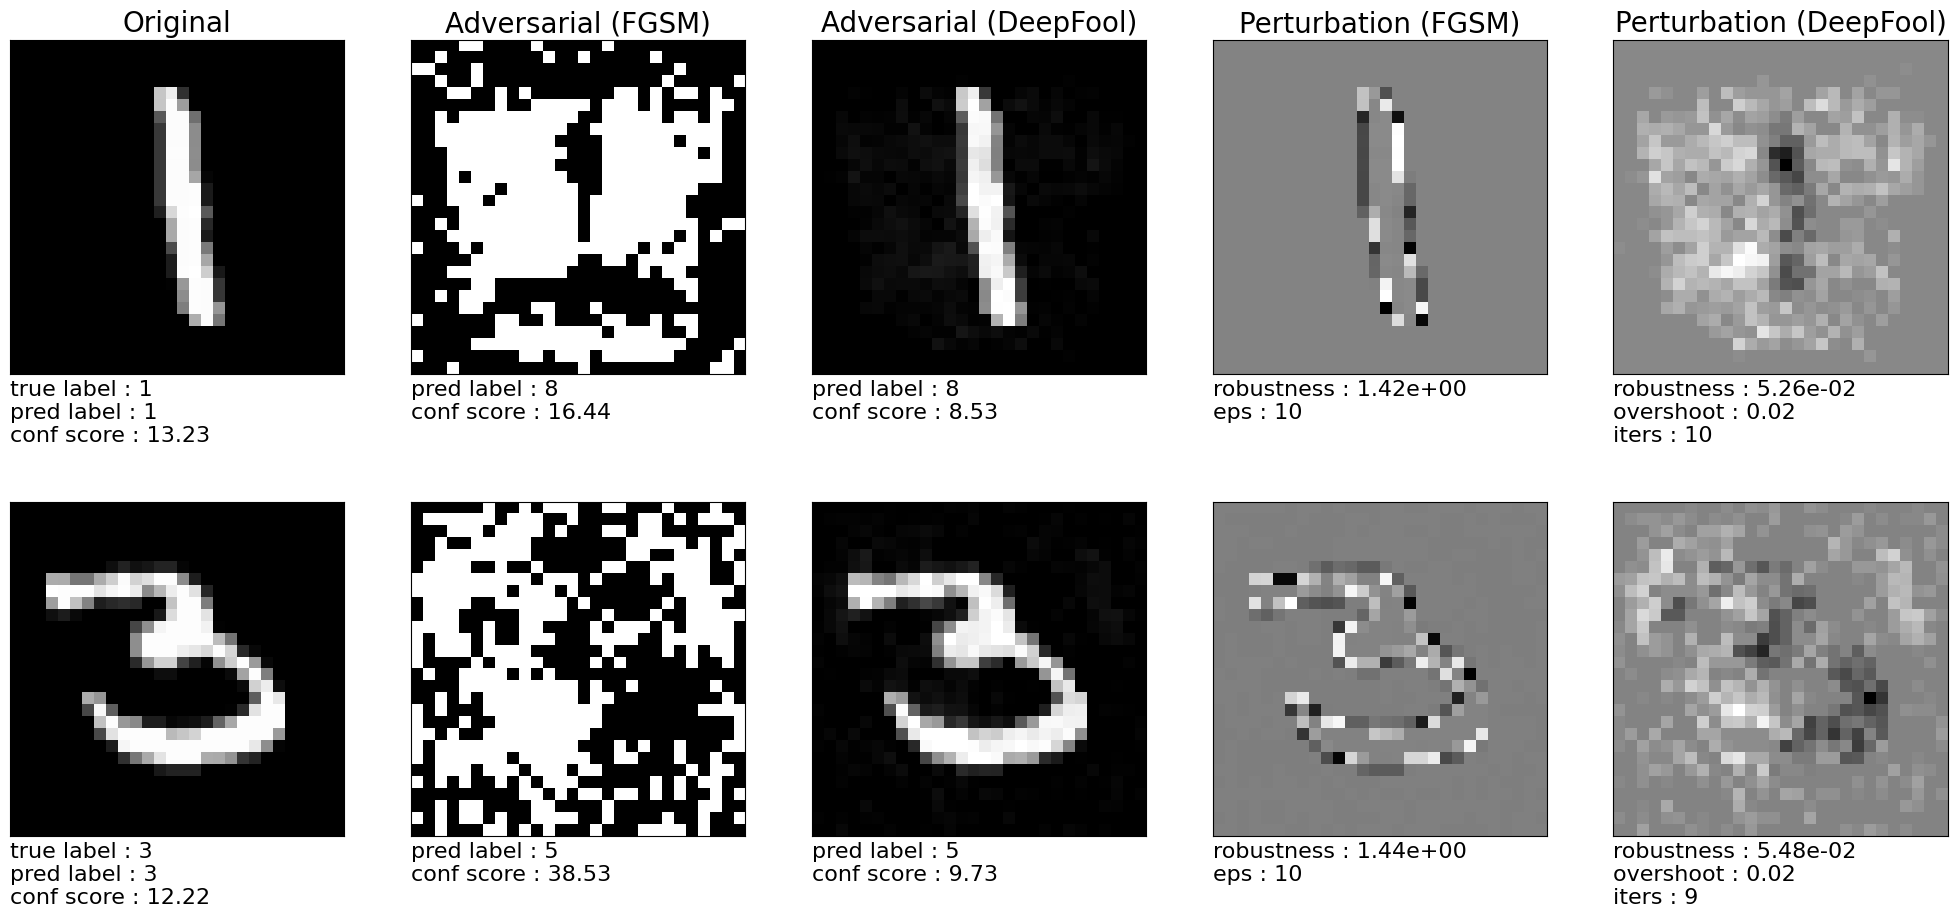

In [129]:
#FCNet
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

for fgsm_eps in [0.001, 0.02, 0.5, 0.9, 10]:
  print(f"Величина fsgsm_eps = {fgsm_eps}:")
  mnist_fc_fgsm = 'mnist_fc_fgsm' + str(fgsm_eps) + '.csv'
  evaluate_attack(mnist_fc_fgsm, 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
  display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
  if device.type == 'cuda': torch.cuda.empty_cache()
  print('')


Величина fsgsm_eps = 0.001:
FGSM Test Error : 10.12%
FGSM Robustness : 8.92e-04
FGSM Time (All Images) : 1.32 s
FGSM Time (Per Image) : 132.40 us


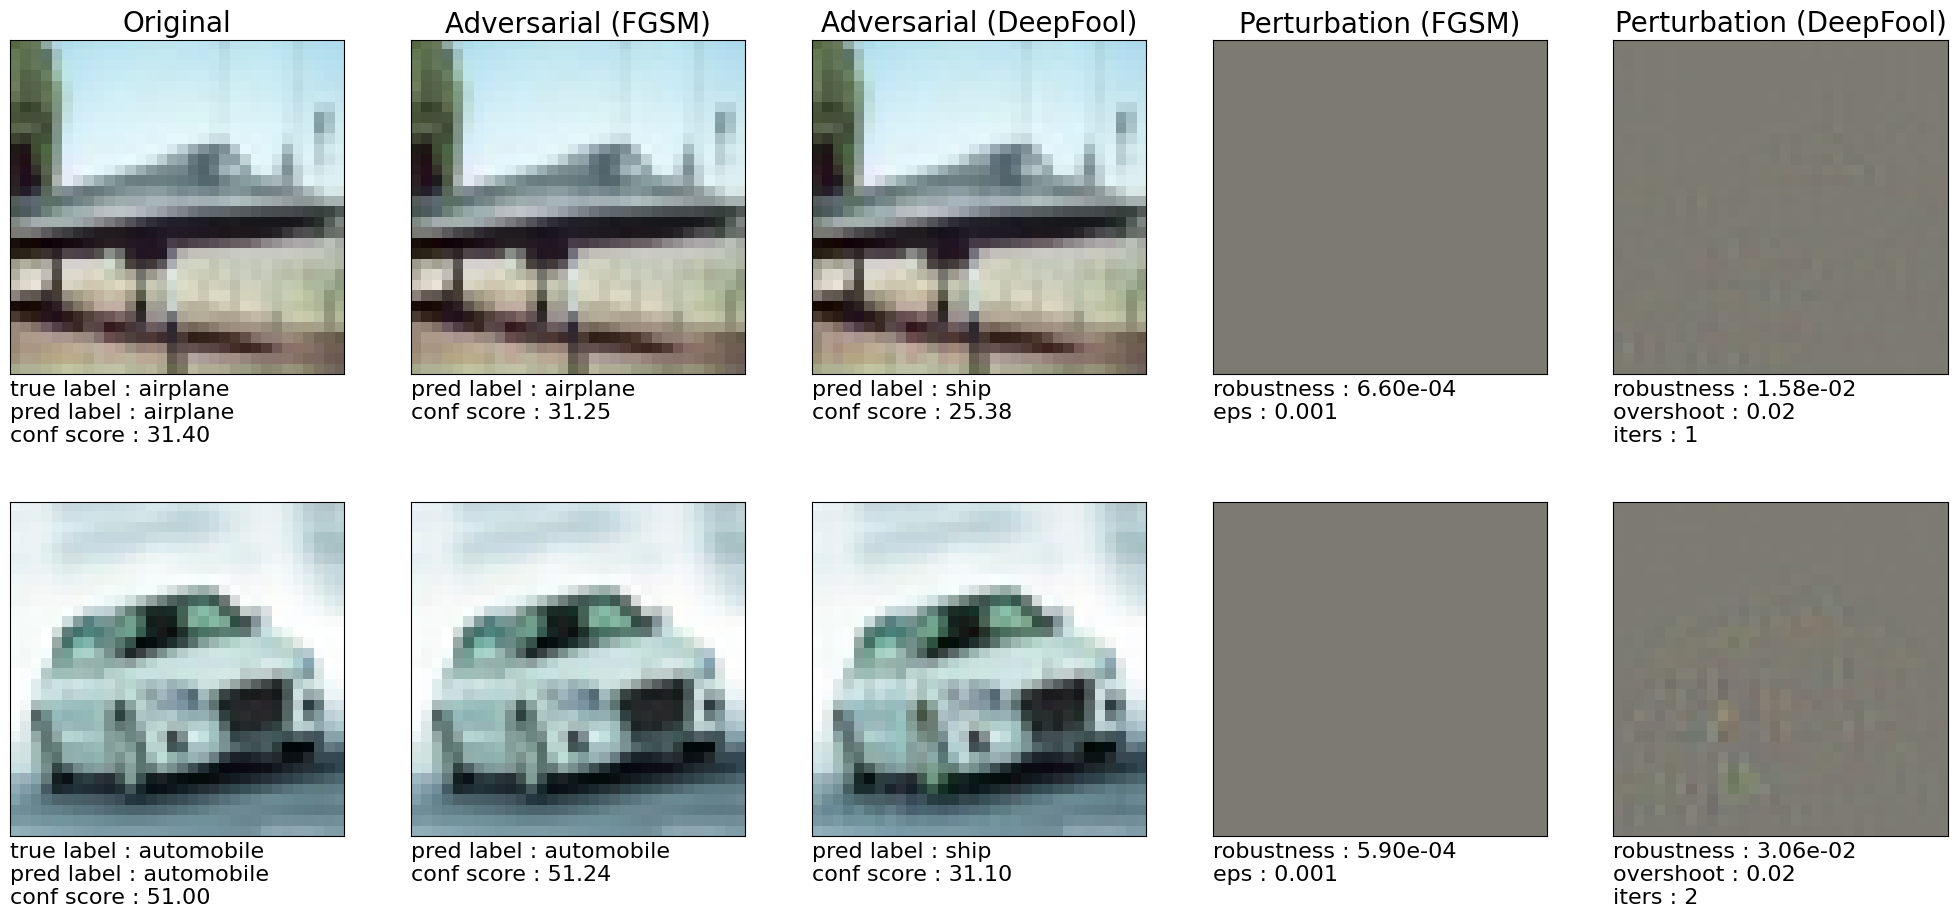


Величина fsgsm_eps = 0.02:
FGSM Test Error : 30.76%
FGSM Robustness : 1.78e-02
FGSM Time (All Images) : 1.13 s
FGSM Time (Per Image) : 112.62 us


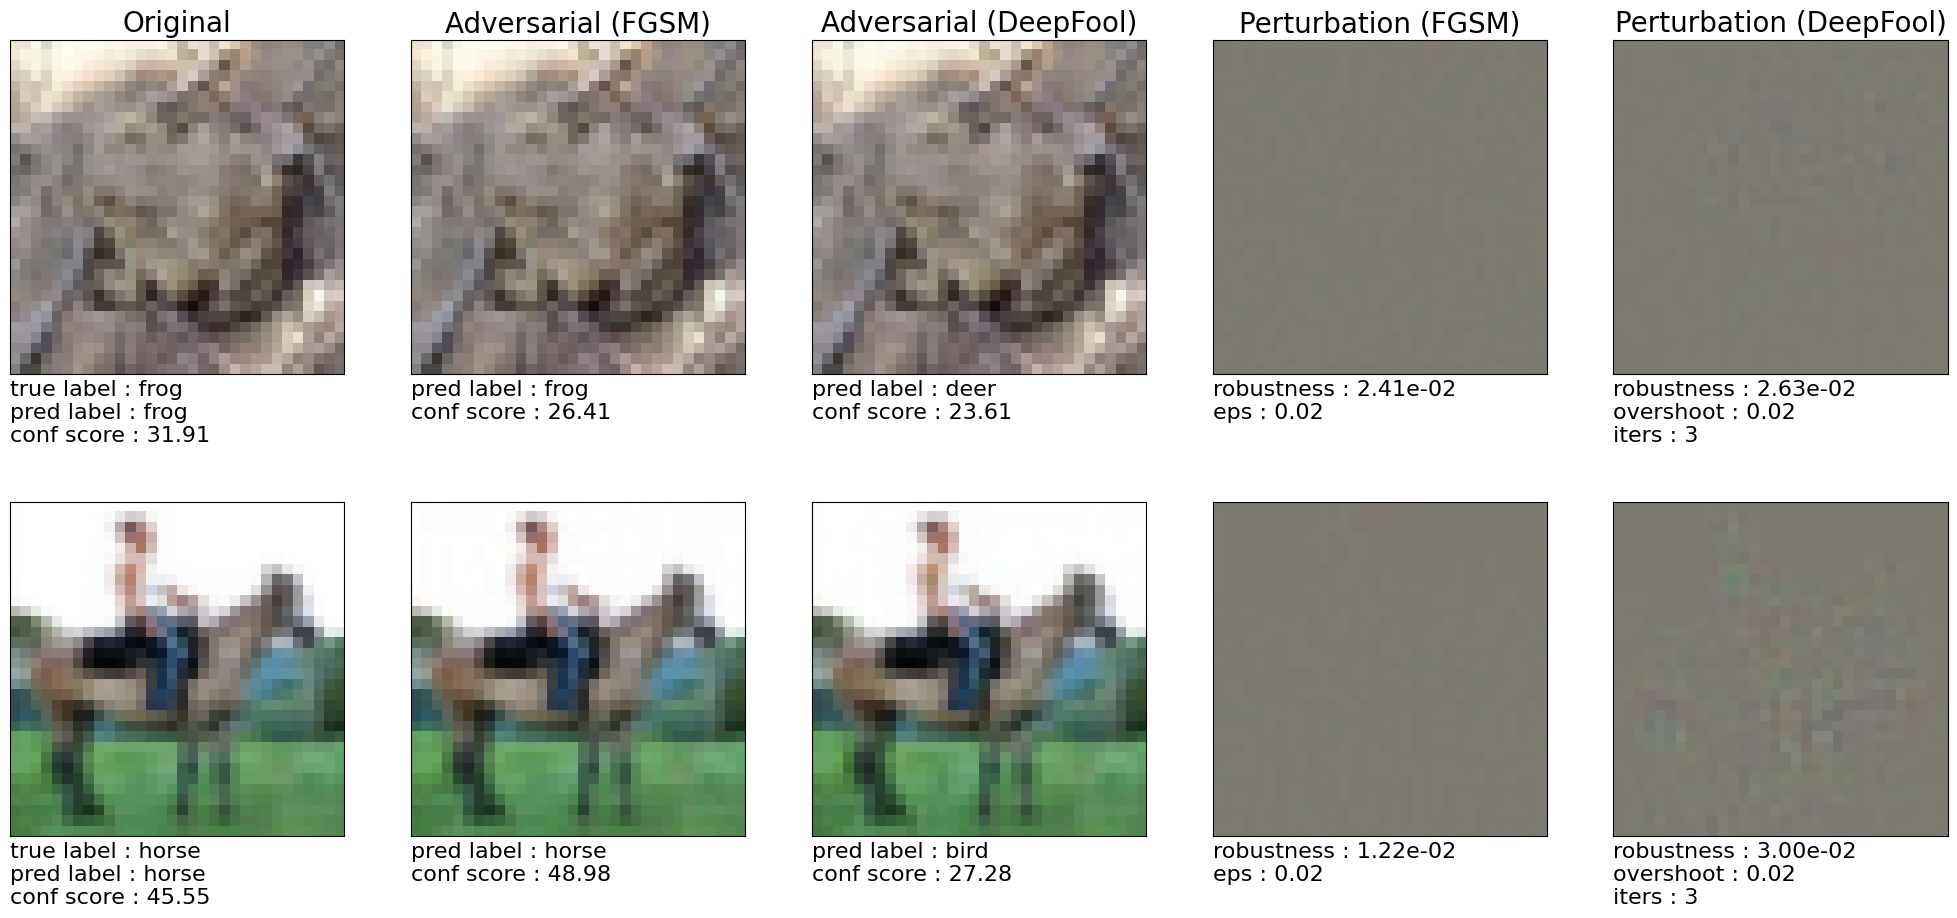


Величина fsgsm_eps = 0.5:
FGSM Test Error : 82.67%
FGSM Robustness : 4.40e-01
FGSM Time (All Images) : 1.13 s
FGSM Time (Per Image) : 112.54 us


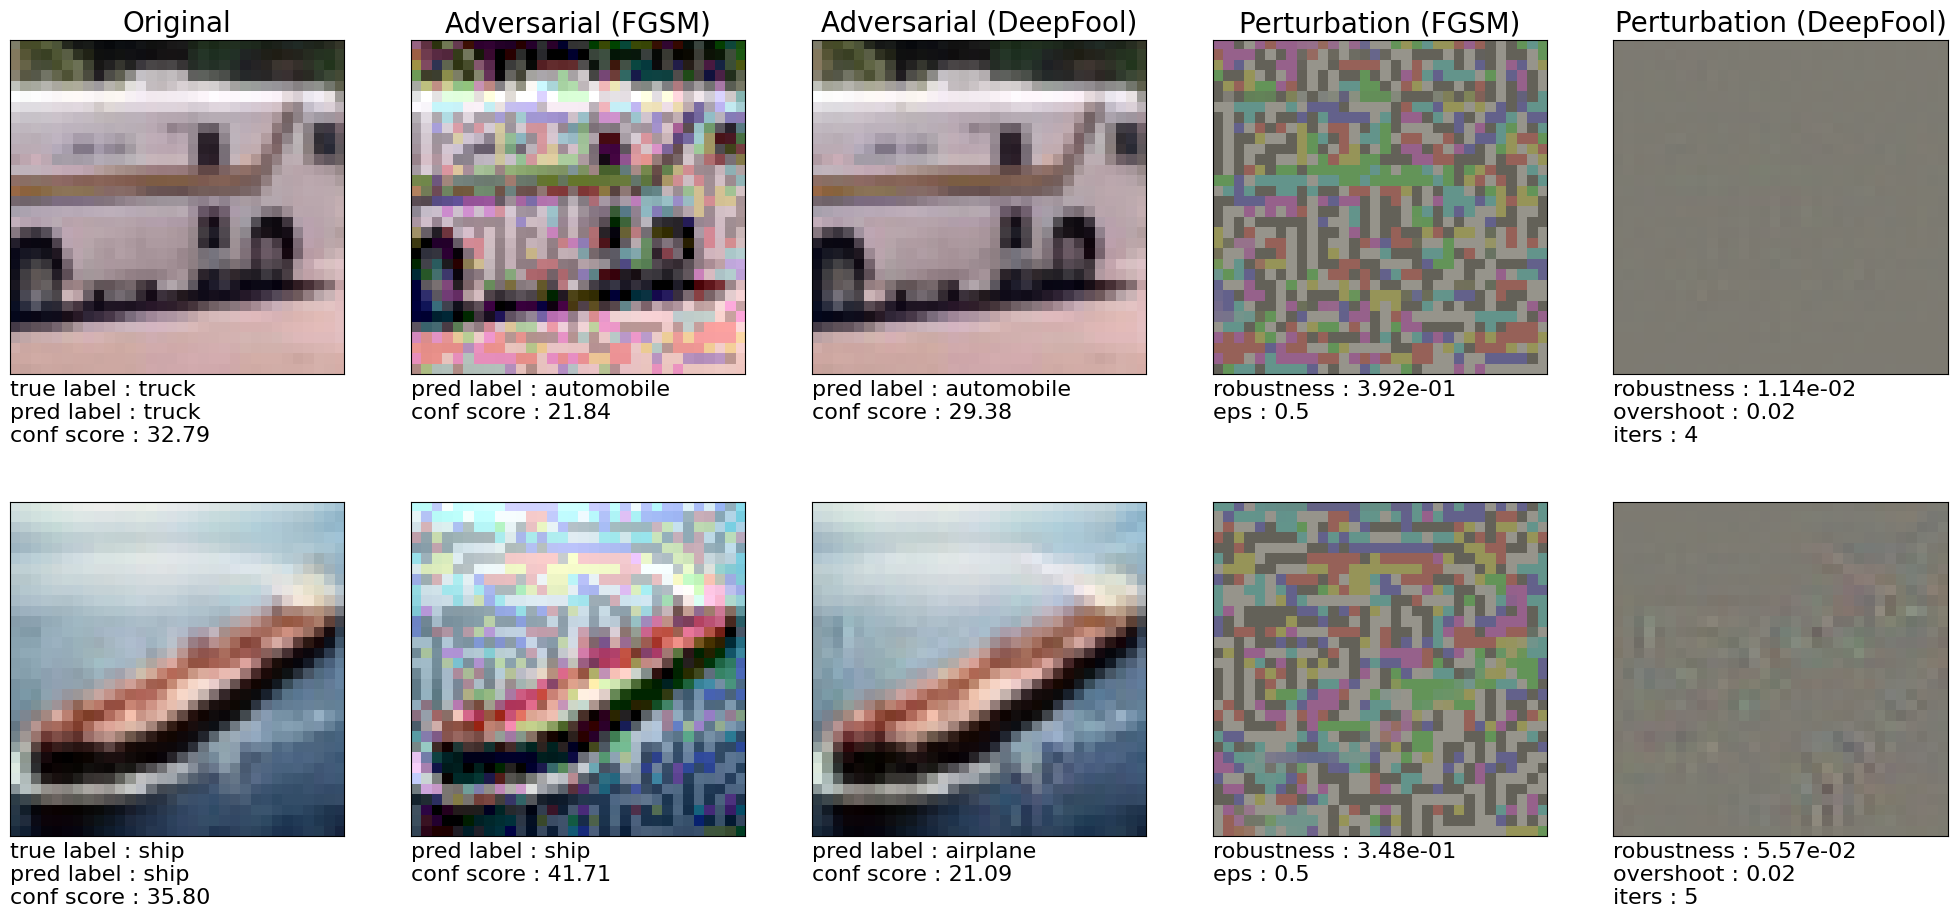


Величина fsgsm_eps = 0.9:
FGSM Test Error : 84.62%
FGSM Robustness : 7.79e-01
FGSM Time (All Images) : 1.37 s
FGSM Time (Per Image) : 137.17 us


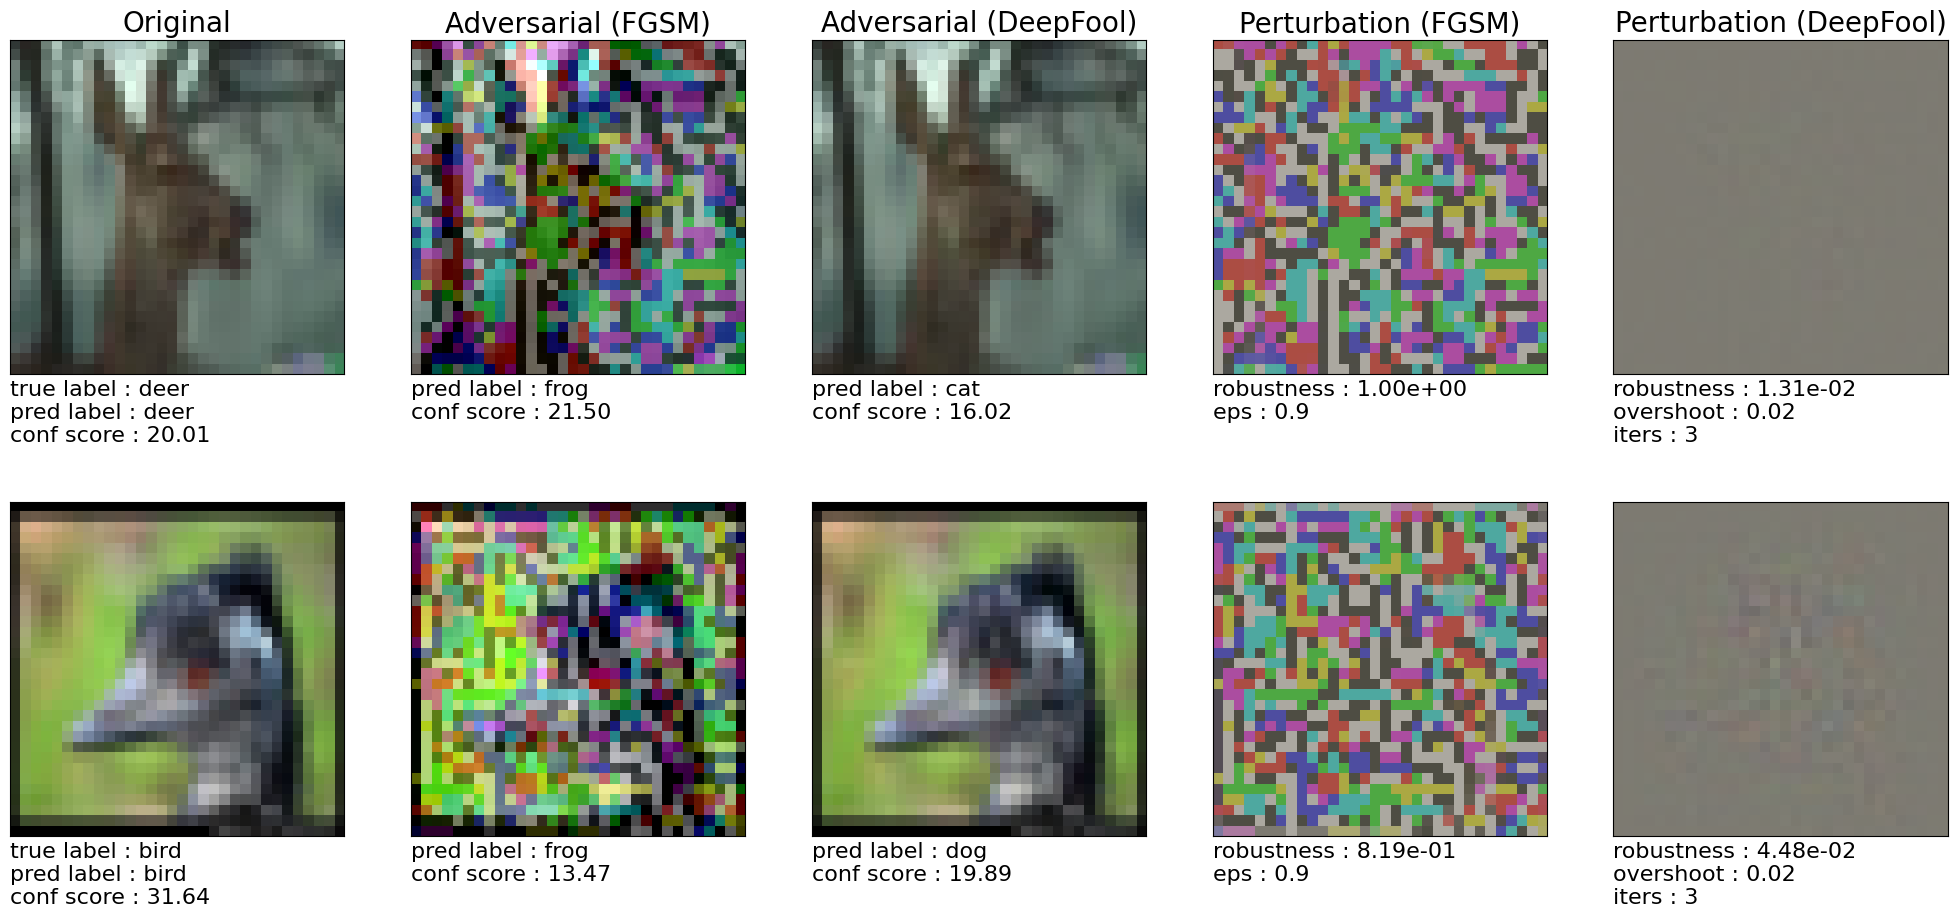


Величина fsgsm_eps = 10:
FGSM Test Error : 87.50%
FGSM Robustness : 2.46e+00
FGSM Time (All Images) : 1.08 s
FGSM Time (Per Image) : 108.25 us


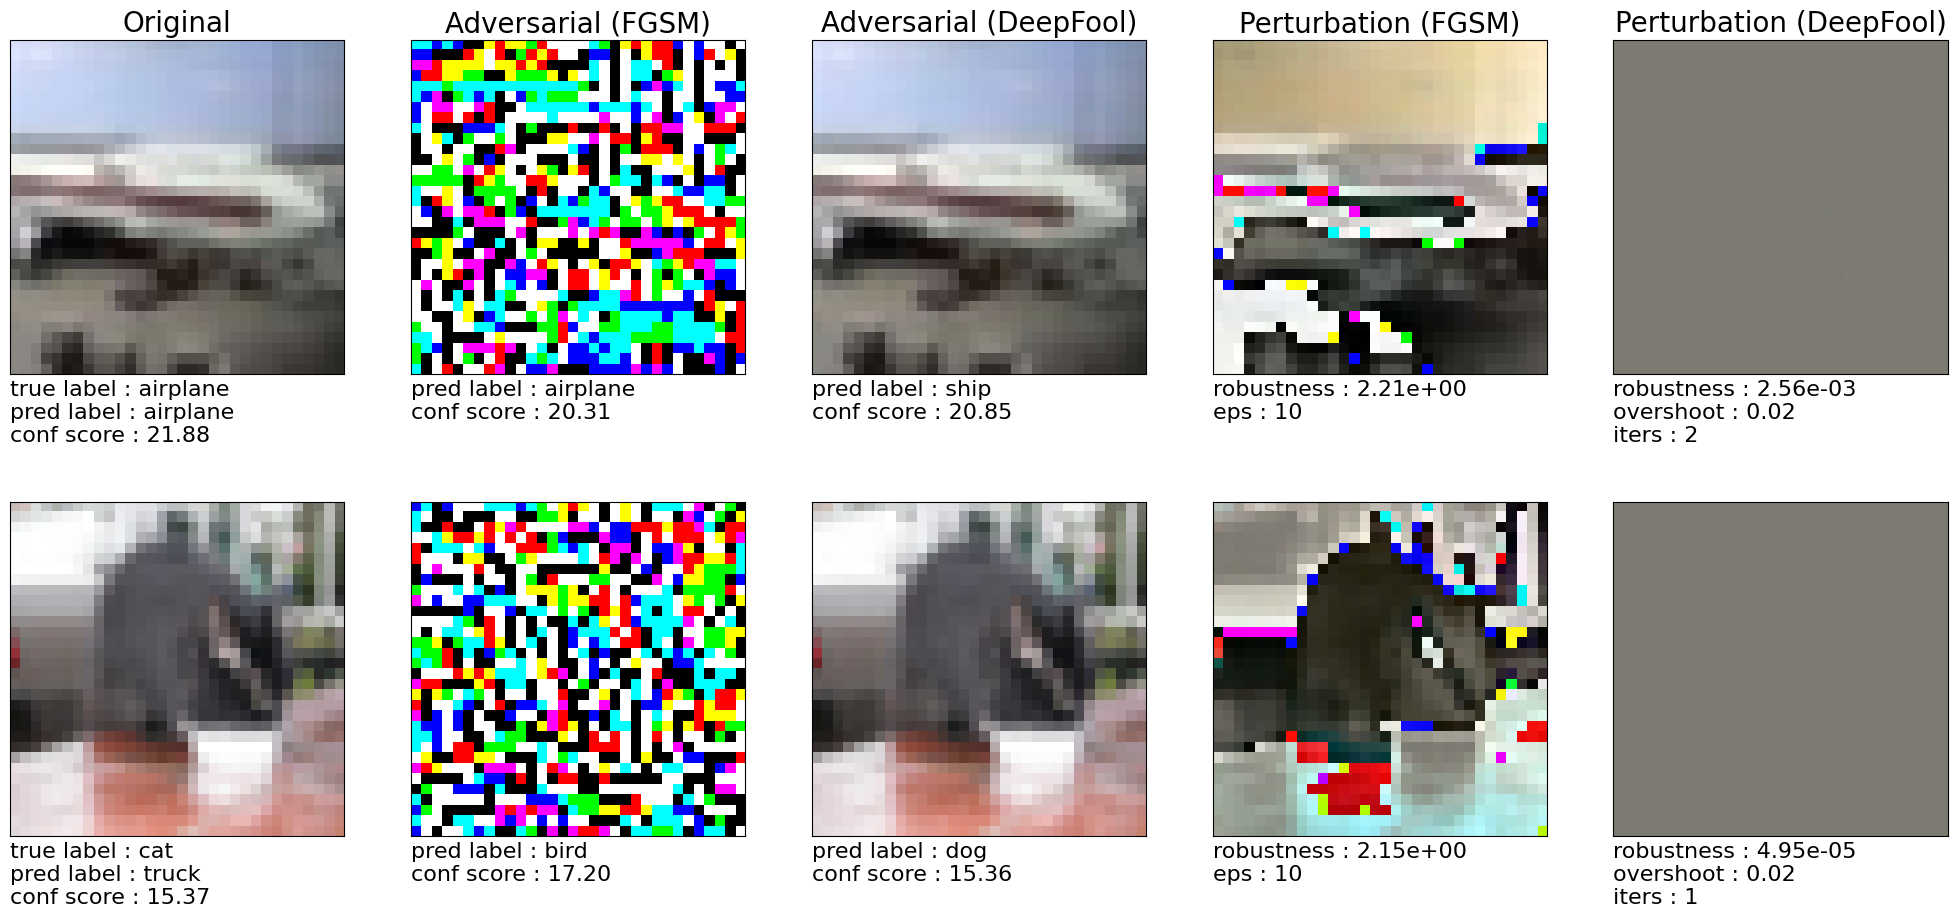

In [126]:
#Network-in-Network
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

for fgsm_eps in [0.001, 0.02, 0.5, 0.9, 10]:
  print(f"Величина fsgsm_eps = {fgsm_eps}:")
  cifar_nin_fgsm = 'cifar_nin_fgsm' + str(fgsm_eps) + '.csv'
  evaluate_attack(cifar_nin_fgsm, 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
  display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)
  if device.type == 'cuda': torch.cuda.empty_cache()
  print('')

Величина fsgsm_eps = 0.001:
FGSM Test Error : 22.72%
FGSM Robustness : 8.92e-04
FGSM Time (All Images) : 1.35 s
FGSM Time (Per Image) : 135.11 us


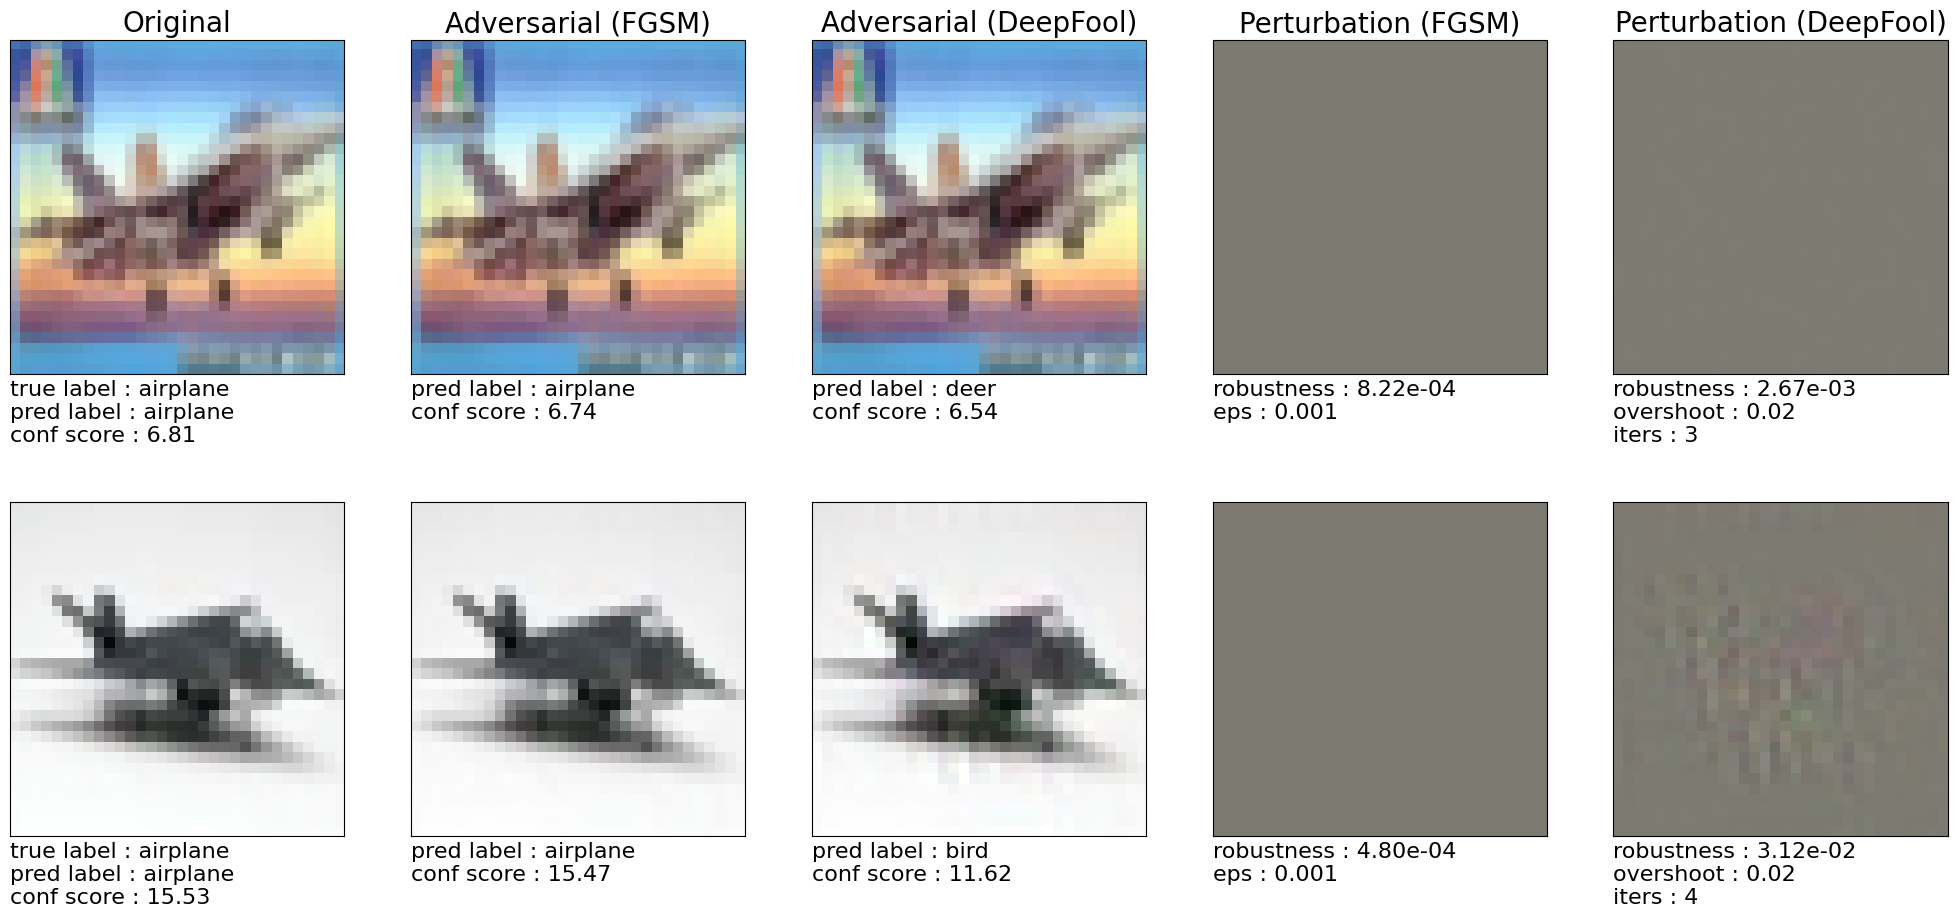


Величина fsgsm_eps = 0.02:
FGSM Test Error : 47.76%
FGSM Robustness : 1.78e-02
FGSM Time (All Images) : 1.27 s
FGSM Time (Per Image) : 126.65 us


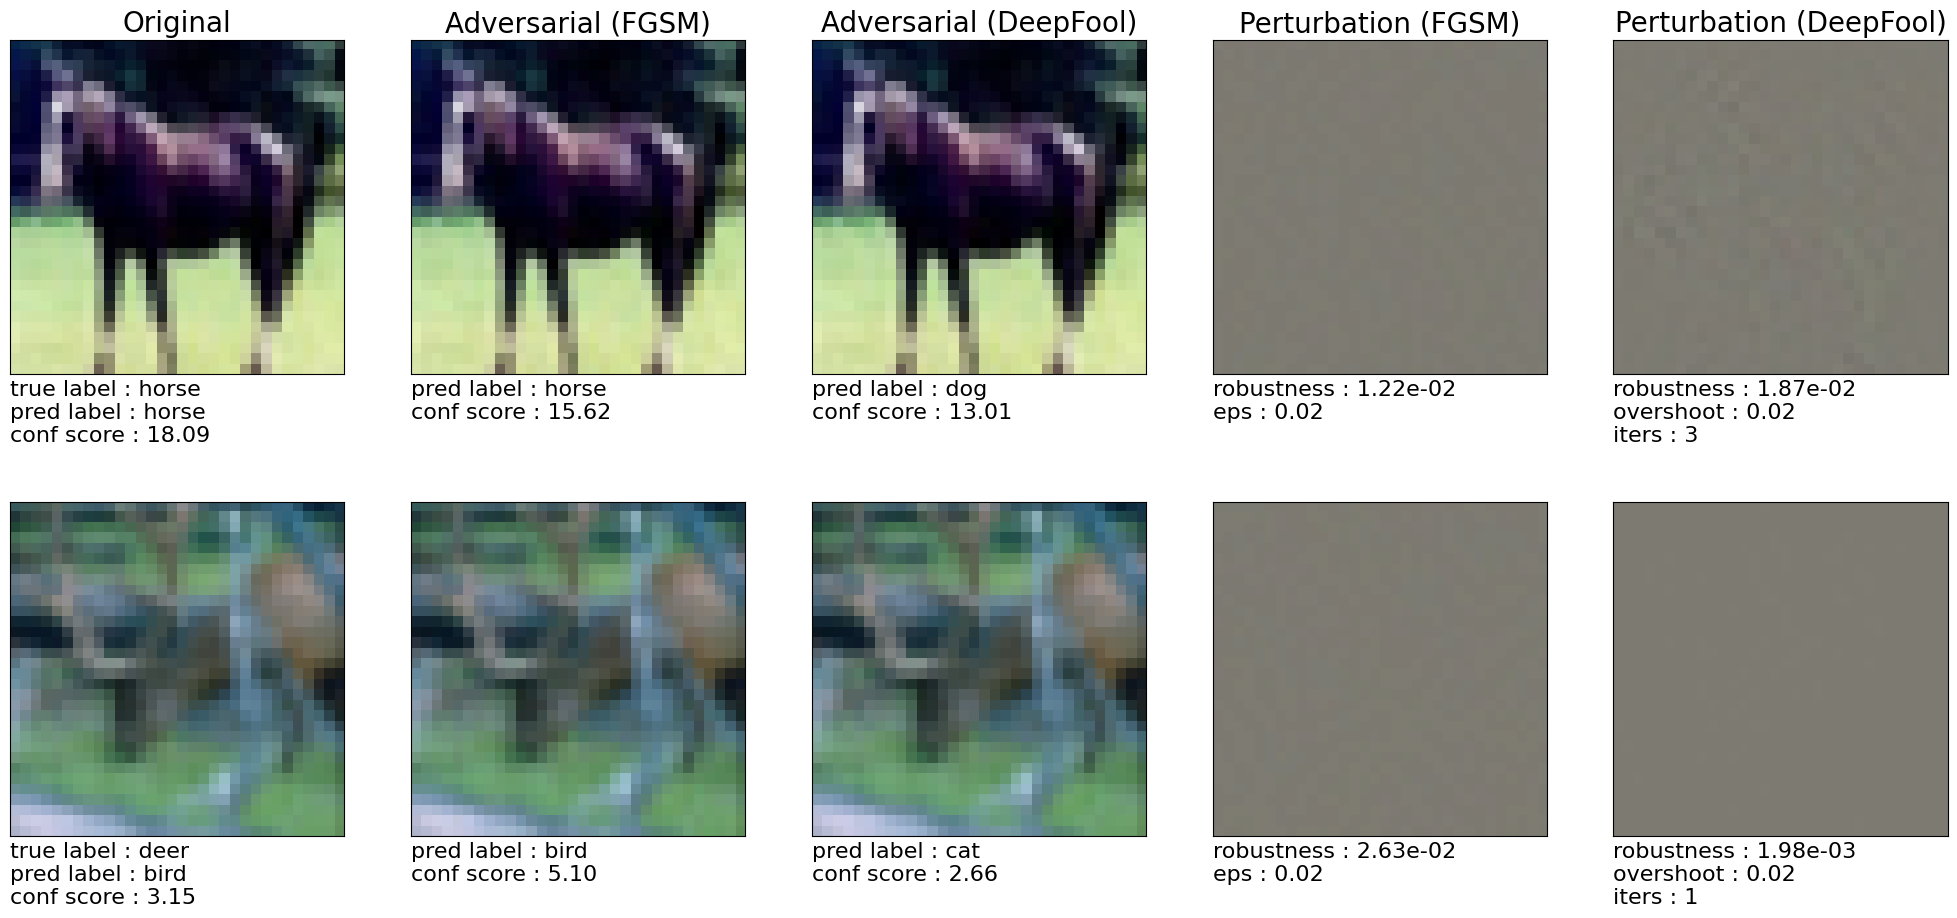


Величина fsgsm_eps = 0.5:
FGSM Test Error : 95.17%
FGSM Robustness : 4.40e-01
FGSM Time (All Images) : 1.21 s
FGSM Time (Per Image) : 121.46 us


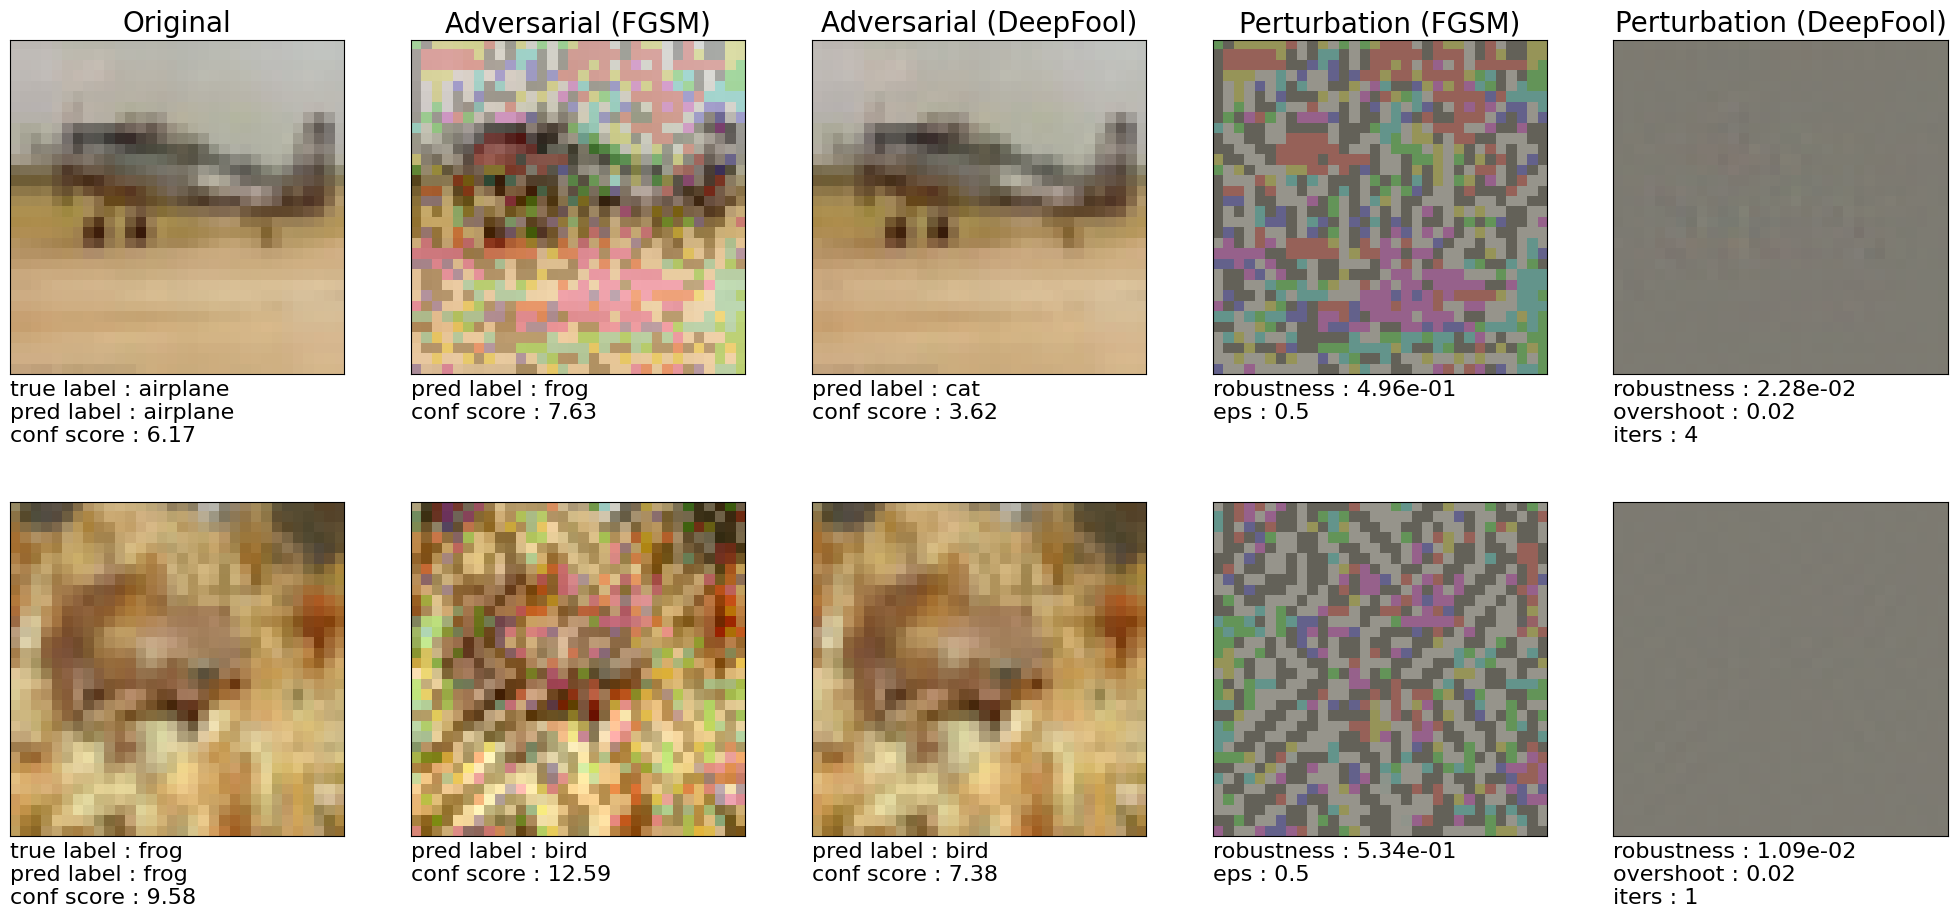


Величина fsgsm_eps = 0.9:
FGSM Test Error : 92.04%
FGSM Robustness : 7.80e-01
FGSM Time (All Images) : 1.45 s
FGSM Time (Per Image) : 145.14 us


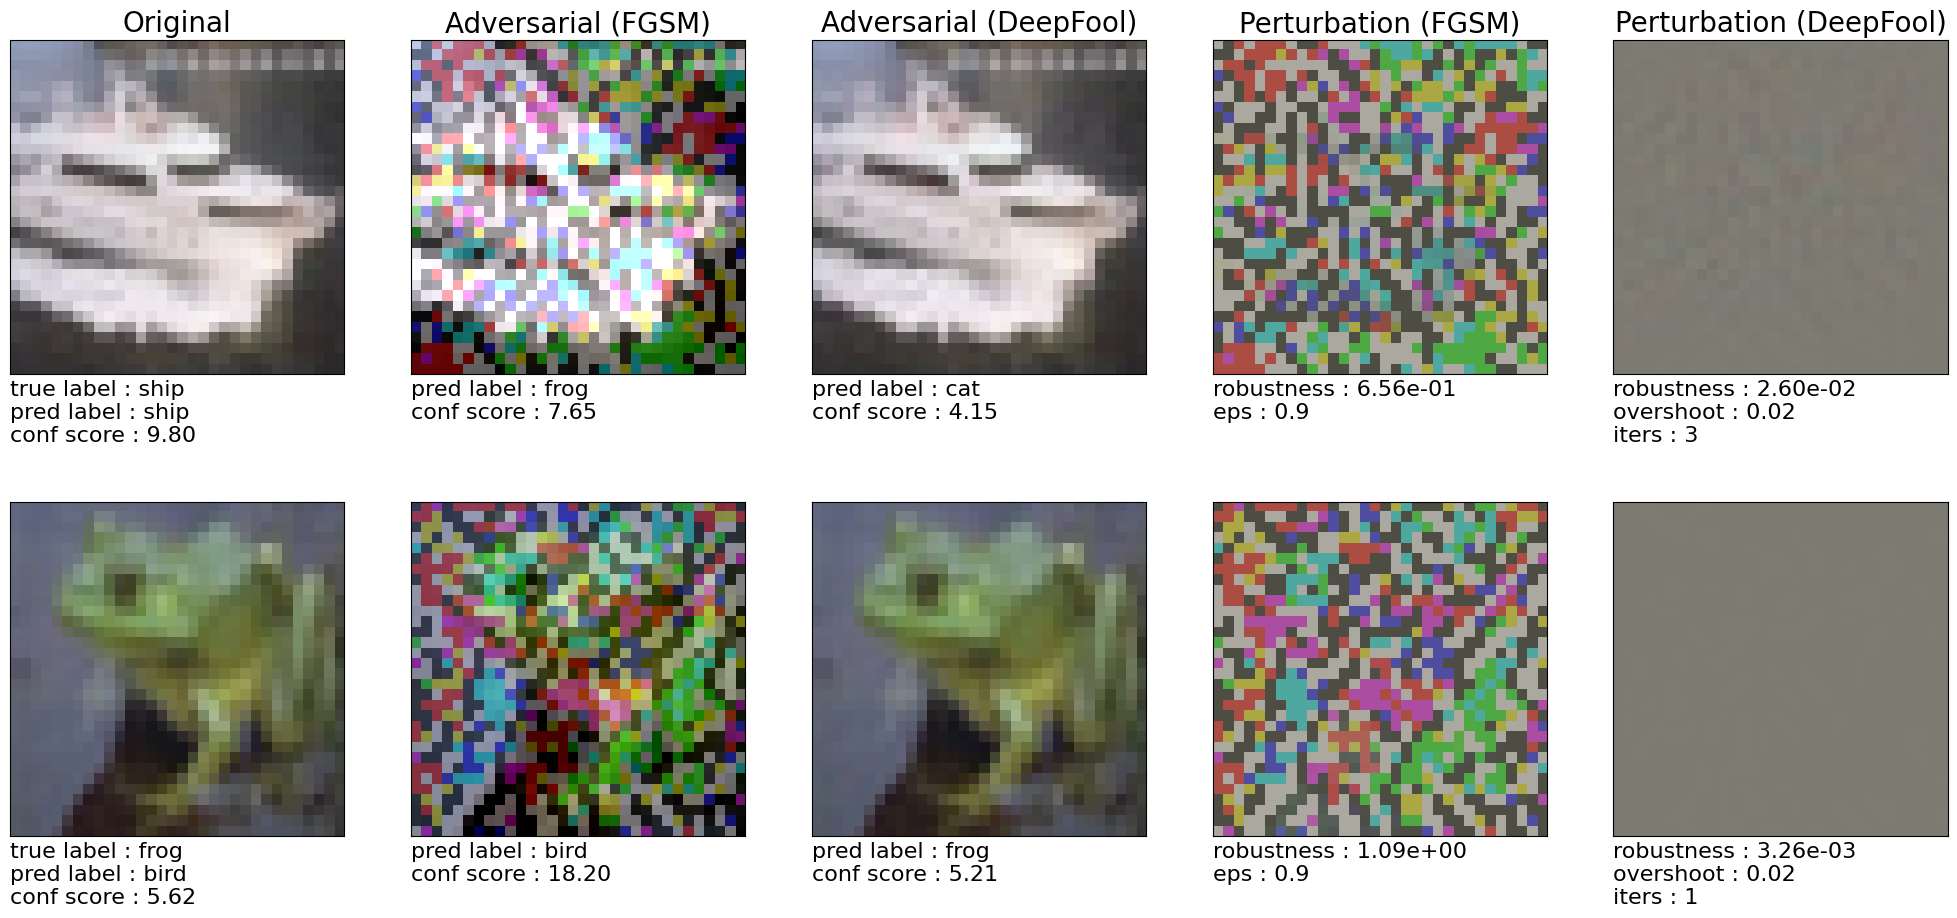


Величина fsgsm_eps = 10:
FGSM Test Error : 89.90%
FGSM Robustness : 2.47e+00
FGSM Time (All Images) : 1.23 s
FGSM Time (Per Image) : 123.39 us


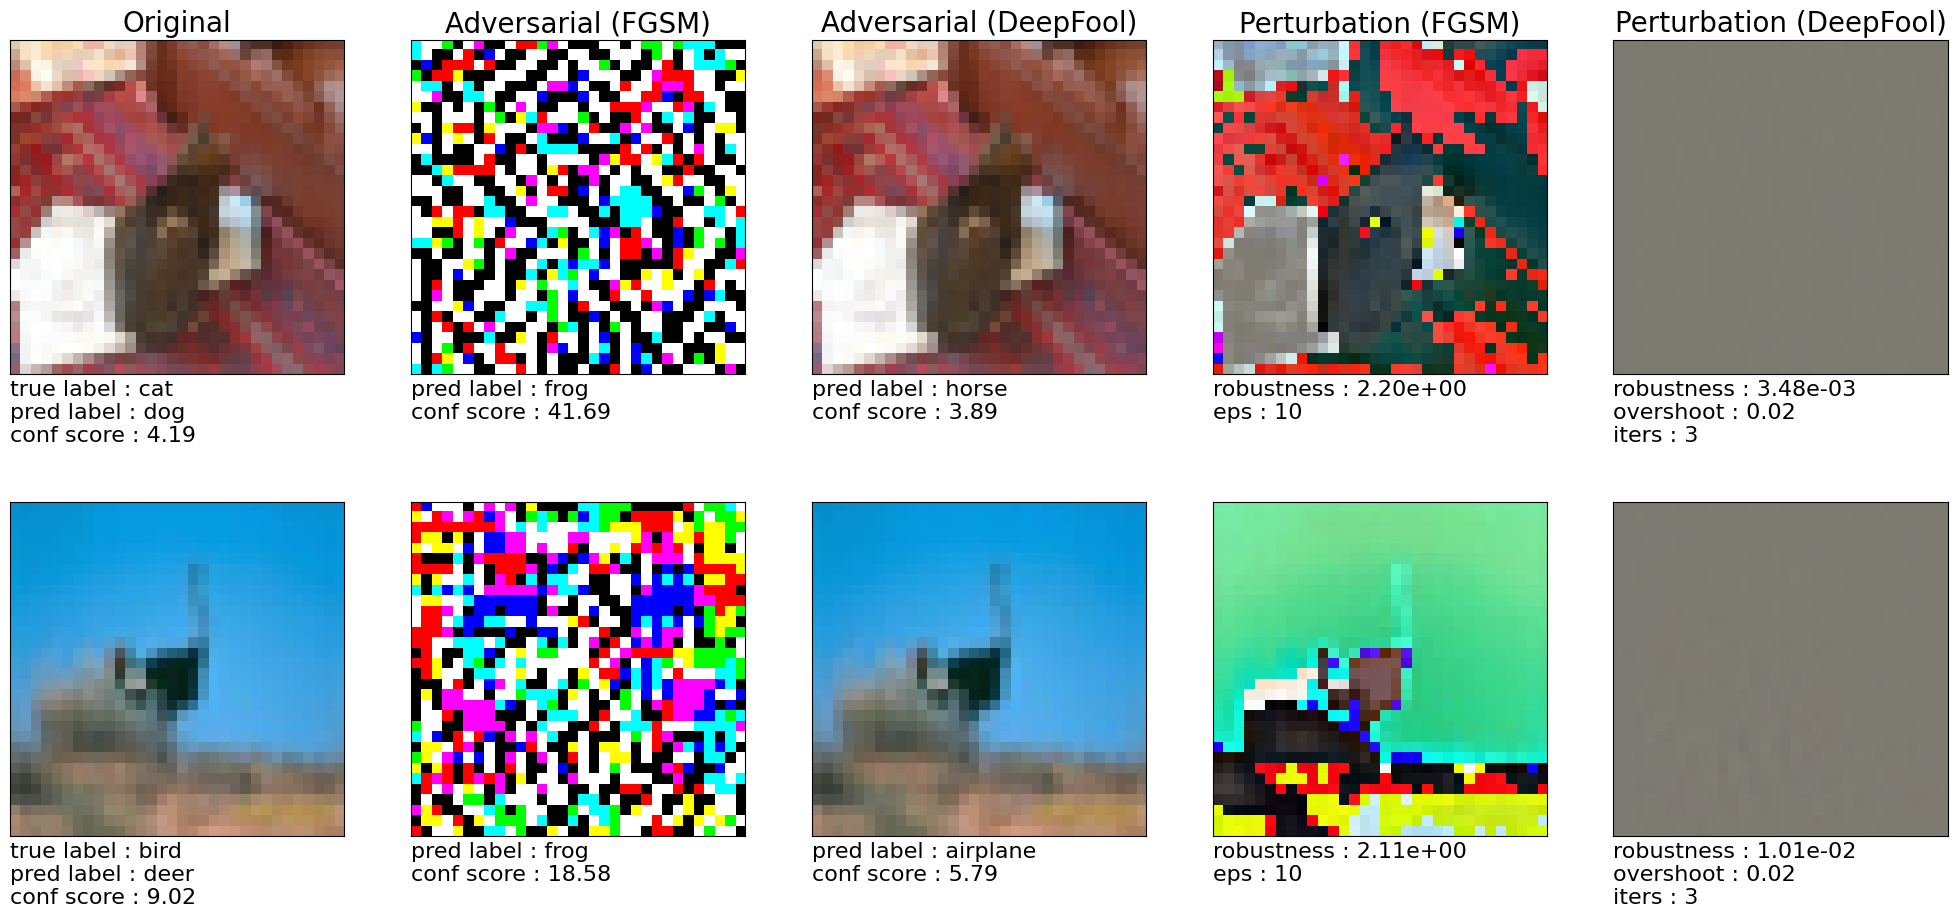

In [128]:
#LeNet CIFAR-10
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

for fgsm_eps in [0.001, 0.02, 0.5, 0.9, 10]:
  print(f"Величина fsgsm_eps = {fgsm_eps}:")
  cifar_lenet_fgsm = 'cifar_lenet_fgsm' + str(fgsm_eps) + '.csv'
  evaluate_attack(cifar_lenet_fgsm, 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
  display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)
  if device.type == 'cuda': torch.cuda.empty_cache()
  print('')

**Вывод:**

Увеличение fgsm_eps увеличивает успешность атаки FGSM, однако чем выше значение, тем сильнее искажается изображение, что становится заметно невооруженным глазом.

LeNet на датасете MNIST выдаёт самую маленькую ошибку на fsgsm_eps = 0.001 - 1.69%, однако на fsgsm_eps = 0.05 она сильно возврастёт до 82.92% и с увеличием fsgsm_eps продолжит расти.

FC на датасете MNIST, выдаёт большие ошибки в отличии LeNet (MNIST), но всё ещё сохраняет небольшие значения при fsgsm_eps 0.01 и 0.02

Network-in-Network показывает изначально большую ошибку,  fsgsm_eps = 0.001:
FGSM Test Error : 10.12%, но немного меньше ошибка на высоких eps в отличие от первых двух, у которых доходит до ~99.8%

LeNet на датасете CIFAR-10 выдаёт самую большую стартовую ошибку fsgsm_eps = 0.001: FGSM Test Error : 22.72%, и самую большую ошибку fsgsm_eps = 0.5:
FGSM Test Error : 95.17%, однако после дальнейшего увеличения fsgsm_eps, ошибка начинает падать, что не замечается у предыдущих трех нейросетей.